In [1]:
import os
print(os.getcwd())
def update_working_directory():
    from pathlib import Path
    p = Path(os.getcwd()).parents[0]
    os.chdir(p)
    print(p)
update_working_directory()

/Users/admin/Projects/doggo/notebooks
/Users/admin/Projects/doggo


# Importing the required libraries

In [2]:
import numpy as np
import pandas as pd
import gym
import time
import math
import statistics
from tqdm import tqdm
import random
from collections import defaultdict
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import dill

# Building the environment

## Parameters specific to the environment

In [3]:
decimals_state = 2
gamma = 0.95 # discount for future rewards (also called decay factor)

## Observation & Action spaces

In [4]:
n_states = (10**decimals_state+1)**3 

action_dict = {
    0: 'NO ACTION',
    1: 'WALKING',
    2: 'EATING',
    3: 'PLAYING'
}
n_actions= len(action_dict)

inv_action_dict = {v: k for k, v in action_dict.items()}

print(n_states, n_actions)

1030301 4


## Reset

In [5]:
def get_state_id(dog_state):
    return '{:01.4f}_{:01.4f}_{:01.4f}_{}'.format(
        dog_state['food'], dog_state['fat'], dog_state['affection'], dog_state['can_action_be_taken'])

In [6]:
def env_reset():
    
    dog_state = {
        'food': 0.5,
        'fat': 0,
        'affection': 0.5,
        'last_action_taken': 0,
        'minutes_since_last_action': 0,
        'can_action_be_taken': True
        }
    
    dog_state['state_id'] = get_state_id(dog_state)
    
    return dog_state

In [7]:
env_reset()

{'food': 0.5,
 'fat': 0,
 'affection': 0.5,
 'last_action_taken': 0,
 'minutes_since_last_action': 0,
 'can_action_be_taken': True,
 'state_id': '0.5000_0.0000_0.5000_True'}

## Next state

In [8]:
WALKING_TIME = 15
EATING_TIME = 1
PLAYING_TIME = 4

food_consumption_rate = 1.0 / (30 * 3600)
affection_consumption_rate = 1.0 / (50 * 3600)
walking_fat_converge_rate = 0.2
walking_affection_converge_rate = 0.4
playing_fat_converge_rate = 0.1
playing_affection_converge_rate = 0.20
eating_food_increase = 0.6
eating_fat_increase = 0.25

In [9]:
def round_up(n, decimals=0):
    multiplier = 10 ** decimals
    return math.ceil(n * multiplier) / multiplier
def round_down(n, decimals=0):
    multiplier = 10 ** decimals
    return math.floor(n * multiplier) / multiplier

In [10]:
def apply_decreasing_rate(value: float, rate: float) -> float:
    """
    Apply a decreasing rate to a value
    :param value: current value
    :param rate: per second
    :return: updated value
    """
    return value - (60 * rate)

def converge(value: float, target: float, ratio: float) -> float:
    diff: float = (target - value) * ratio
    return value + diff


def update_food(dog_state):
    update_food = apply_decreasing_rate(dog_state['food'], food_consumption_rate)
    return round_down(max(0.0, update_food), decimals=decimals_state)

def update_fat(dog_state):
    update_fat = dog_state['fat']
    return update_fat

def update_affection(dog_state):
    update_affection = apply_decreasing_rate(dog_state['affection'], affection_consumption_rate)
    return round_down(max(0.0, update_affection), decimals=decimals_state)


def update_if_walking(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, walking_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, walking_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)

def update_if_feeding(dog_state):
    update_food = round_up(min(dog_state['food'] + eating_food_increase, 1.0), decimals=decimals_state)
    update_fat = round_up(min(dog_state['fat'] + eating_fat_increase, 1.0), decimals=decimals_state)
    return (update_food, update_fat)

def update_if_playing(dog_state):
    update_fat = round_down(converge(dog_state['fat'], 0.0, playing_fat_converge_rate), decimals=decimals_state)
    update_affection = round_up(converge(dog_state['affection'], 1.0, playing_affection_converge_rate), decimals=decimals_state)
    return (update_fat, update_affection)


def get_happiness(dog_state):
    happiness = min(dog_state['food'], 1.0 - dog_state['fat'], dog_state['affection'])
    return happiness


def update_done(dog_state):
    happiness = get_happiness(dog_state)
    return happiness <= 0.0

In [11]:
# state2, reward1, done, info = env.step(action1)
def env_step(state1, action):
    
    state2 = state1.copy()
    reward_penalty = 0
    
    # Affect of time
    state2['food'] = update_food(state2)
    state2['fat'] = update_fat(state2)
    state2['affection'] = update_affection(state2)
    state2['minutes_since_last_action'] += 1 
    
    # Applying action
    if action != 0:
        if state2['can_action_be_taken']:
            reward_penalty += 0.1
            state2['can_action_be_taken'] = False
            state2['minutes_since_last_action'] = 0
            state2['last_action_taken'] = action
        else:
            reward_penalty += 0.5

    # Affect of actions
    if (state2['last_action_taken'] == 1) & (state2['minutes_since_last_action'] == WALKING_TIME):
        state2['fat'], state2['affection'] = update_if_walking(state2)
        state2['can_action_be_taken'] = True

    if (state2['last_action_taken'] == 2) & (state2['minutes_since_last_action'] == EATING_TIME):
        state2['food'], state2['fat'] = update_if_feeding(state2)
        state2['can_action_be_taken'] = True

    if (state2['last_action_taken'] == 3) & (state2['minutes_since_last_action'] == PLAYING_TIME):
        state2['fat'], state2['affection'] = update_if_playing(state2)
        state2['can_action_be_taken'] = True
                    
    done = update_done(state2)
    if done:
        reward = -10
    else:
        reward = min(state2['food'], 1.0 - state2['fat'], state2['affection']) - reward_penalty
    
    info = None
    
    state2['state_id'] = get_state_id(state2)
    
    return (state2, reward, done, info)

## Render

In [12]:
def env_render(dog_state, action, Q):
    print(dog_state)
    print(action)
    print(Q[dog_state['state_id']])

# Defining utility functions to be used in the learning process

## Initialising Q

In [13]:
def init_Q(n_actions, init_Q_type="ones"):
    """
    @param n_actions the number of actions
    @param type random, ones or zeros for the initialization
    """
    if init_Q_type == "ones":
        default_Q_values = np.ones(n_actions)
    elif init_Q_type == "random":
        default_Q_values = np.random.random(n_actions)
    elif init_Q_type == "zeros":
        default_Q_values = np.zeros(n_actions)
    
    def get_default_Q_values():
        return default_Q_values

    return defaultdict(get_default_Q_values)

## Initialising N

In [14]:
def init_N(n_actions):
    """
    @param n_actions the number of actions
    """
    default_N_values = np.zeros(n_actions)
    
    def get_default_N_values():
        return default_N_values

    return defaultdict(get_default_N_values)

## Choose an action

In [15]:
# Numpy generator
rng = np.random.default_rng()  # Create a default Generator.

In [16]:
def select_best_action(Q_state):
    winner = np.argwhere(Q_state == np.amax(Q_state))
    winner_list = winner.flatten().tolist()
    action = random.choice(winner_list)
    return action

### $\epsilon$-Greedy

In [17]:
def epsilon_greedy(Q, state_id, n_actions, epsilon, Q2 = None):
    """
    @param Q Q values {state, action} -> value
    @param epsilon for exploration
    @param n_actions number of actions
    @param state state at time t
    """
    if rng.uniform(0, 1) < epsilon:
        action = np.random.randint(0, n_actions)
    else:
        if not Q2:
            action = select_best_action(Q[state_id])
        else:
            action = select_best_action(Q[state_id] + Q2[state_id])
    
    return action

## Discounted reward

In [18]:
def get_discounted_reward(t, l_rewards_episode, gamma):
    l_discounted_reward_episode = [t_prime_reward*(gamma**t_prime) for (t_prime, t_prime_reward) in enumerate(l_rewards_episode[t:])]
    G_k_t = sum(l_discounted_reward_episode)
    return G_k_t

def add_discounted_reward(steps_episode, gamma):
    l_rewards_episode = [step_episode['reward'] for step_episode in steps_episode]
    for (t, step_episode) in enumerate(steps_episode):
        step_episode['discounted_reward'] = get_discounted_reward(t, l_rewards_episode, gamma)

## Update N-matrice

In [19]:
def update_N_MC(N, step_episode, method_monte_carlo, states_already_visited=[]):
    
    state_id = step_episode['state']['state_id']
    action = step_episode['action']
    
    previous_N_value_state = N[state_id].copy()
    
    if method_monte_carlo == 'first_visit':
        if not state_id in states_already_visited:
            new_N_value = N[state_id][action] + 1
            previous_N_value_state[action] = new_N_value
    
    if method_monte_carlo == 'every_visit':
        new_N_value = N[state_id][action] + 1
        previous_N_value_state[action] = new_N_value

    N[state_id] = previous_N_value_state
    
    return N

## Update Q-matrice (state-action value function)

### Monte-Carlo

In [20]:
def update_Q_MC(Q, N, step_episode, method_monte_carlo, states_already_visited=[]):
    
    state_id = step_episode['state']['state_id']
    action = step_episode['action']
    G_k_t = step_episode['discounted_reward']
    
    previous_Q_value_state = Q[state_id].copy()
    
    if method_monte_carlo == 'first_visit':
        if not state_id in states_already_visited:
            new_Q_value = Q[state_id][action] + (G_k_t - Q[state_id][action]) / N[state_id][action]
            previous_Q_value_state[action] = new_Q_value
    
    if method_monte_carlo == 'every_visit':
        new_Q_value = Q[state_id][action] + (G_k_t - Q[state_id][action]) / N[state_id][action]
        previous_Q_value_state[action] = new_Q_value

    Q[state_id] = previous_Q_value_state
    
    return Q

### SARSA

In [21]:
# Function to learn the Q-value  - Is it temporal-difference?
def update_Q_SARSA(Q, state1_id, action1, reward1, state2_id, action2, expected=False):
    
    previous_Q_value_state1 = Q[state1_id].copy()
    
    predict = Q[state1_id][action1] 
    
    target = reward1 + gamma * Q[state2_id][action2] 
    if expected:
        expected_value = np.mean(Q[state2_id])
        target = reward1 + gamma * expected_value
    
    new_Q_value = Q[state1_id][action1] + alpha * (target - predict)
    previous_Q_value_state1[action1] = new_Q_value
    
    Q[state1_id] = previous_Q_value_state1
        
    return Q

### Q-learning

In [22]:
# Function to learn the Q-value 
def update_Q_Qlearning(Q, state1_id, action1, reward1, state2_id, action2, expected=False):
    
    previous_Q_value_state1 = Q[state1_id].copy()
    
    predict = Q[state1_id][action1] 
    
    target = reward1 + gamma * Q[state2_id][action2] 
    
    new_Q_value = Q[state1_id][action1] + alpha * (target - predict)
    previous_Q_value_state1[action1] = new_Q_value
    
    Q[state1_id] = previous_Q_value_state1
    
    return Q

### Double Q-learning

In [23]:
# Function to learn the Q-value 
def update_Q_doubleQlearning(Q1, Q2, state1_id, action1, reward1, state2_id, action2, expected=False):
    
    previous_Q_value_state1 = Q1[state1_id].copy()
    
    predict = Q1[state1_id][action1] 
    
    target = reward1 + gamma * Q2[state2_id][action2] 
    
    new_Q_value = Q1[state1_id][action1] + alpha * (target - predict)
    previous_Q_value_state1[action1] = new_Q_value
    
    Q1[state1_id] = previous_Q_value_state1
    
    return Q1

## Updating parameters

### Epsilon $\epsilon$ - Exploration rate

In [24]:
def get_epsilon(episode, init_epsilon):
    
    n_epsilon = init_epsilon/(episode*10+1)
    
    return n_epsilon

### Alpha $\alpha$ - Learning rate

In [25]:
def get_alpha(episode, init_alpha):
    
    n_alpha = init_alpha/(episode*10+1)
    
    return n_alpha

## Plots Reward / Steps / Happiness

In [26]:
import matplotlib.colors as colors

def get_list_colors():
    colors_list = ['r','g','b','k','darkorange','y','lime','c','m'] + list(colors._colors_full_map.values())
    return colors_list

colors = get_list_colors()

In [27]:
import numpy as np
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

### Reward

In [28]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_reward(evolution_reward, method_name):
    
    n_moving_points = int(np.ceil(len(evolution_reward)/100))
    y = running_mean(evolution_reward,n_moving_points)
    x = range(len(y))

    info_parameters = '{} method - {} steps \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        method_name, len(evolution_reward), init_epsilon, init_alpha, gamma, nmax_steps)
    
    plt.plot(x, y)
    plt.title('Evolution of Avg Reward per step per episode over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Avg Reward per step per episode (Smoothed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/{}__reward.png'.format(method_name), format='png', dpi=500)
    plt.show()

In [29]:
def plot_comparison_evolution_reward(evo_training__evo_avg_reward_per_step):

    n_episodes = len(list(evo_training__evo_avg_reward_per_step.values())[0])
    info_parameters = 'All methods - {} episodes \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        n_episodes, init_epsilon, init_alpha, gamma, nmax_steps)

    fig = plt.figure()
    cnt=0
    for method in list(evo_training__evo_avg_reward_per_step.keys()):

        n_moving_points = int(np.ceil(len(evo_training__evo_avg_reward_per_step[method])/20))
        y = running_mean(evo_training__evo_avg_reward_per_step[method], n_moving_points)
        x = range(len(y))

        plt.plot(
            x
            , y
            , label=method
            , marker='', color=colors[cnt], linewidth=1, alpha=0.75
        )
        cnt += 1

    plt.title('Evolution of Avg Reward per step per episode over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Avg Reward per step \n per episode (Smoothed)')
    plt.legend(bbox_to_anchor=(0.5,-0.10), loc="lower center", 
                bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/Comparison__reward.png', format='png', dpi=500)
    plt.show()

### Number of steps

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_steps(evolution_steps, method_name):
    
    n_moving_points = int(np.ceil(len(evolution_steps)/100))
    y = running_mean(evolution_steps,n_moving_points)
    x = range(len(y))

    info_parameters = '{} method - {} steps \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        method_name, len(evolution_steps), init_epsilon, init_alpha, gamma, nmax_steps)
    
    plt.plot(x, y)
    plt.title('Episode Length over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.axhline(nmax_steps, color = 'r')
    plt.axhline(0, color = 'b')
    plt.ylim([-10, nmax_steps*1.05])
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Episode Length (Smoothed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/{}__steps.png'.format(method_name), format='png', dpi=500)
    plt.show()

In [31]:
def plot_comparison_evolution_steps(evo_training__evo_n_steps):

    n_episodes = len(list(evo_training__evo_n_steps.values())[0])
    info_parameters = 'All methods - {} episodes \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        n_episodes, init_epsilon, init_alpha, gamma, nmax_steps)

    fig = plt.figure()
    cnt=0
    for method in list(evo_training__evo_n_steps.keys()):

        n_moving_points = int(np.ceil(len(evo_training__evo_n_steps[method])/20))
        y = running_mean(evo_training__evo_n_steps[method], n_moving_points)
        x = range(len(y))

        plt.plot(
            x, y, label=method
            , marker='', color=colors[cnt], linewidth=1, alpha=0.75
        )
        cnt += 1

    plt.title('Episode Length over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.axhline(nmax_steps, color = 'r')
    plt.axhline(0, color = 'b')
    plt.ylim([-10, nmax_steps*1.05])
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Episode Length (Smoothed)')
    plt.legend(bbox_to_anchor=(0.5,-0.10), loc="lower center", 
            bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/Comparison__steps.png', format='png', dpi=500)
    plt.show()

### Happiness

In [32]:
import numpy as np
import matplotlib.pyplot as plt

def plot_evolution_happiness(evolution_happiness_all, method_name):
    
    n_moving_points = int(np.ceil(len(evolution_happiness_all)/100))
    y = running_mean(evolution_happiness_all,n_moving_points)
    x = range(len(y))

    info_parameters = '{} method - {} steps \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        method_name, len(evolution_happiness_all), init_epsilon, init_alpha, gamma, nmax_steps)
    
    plt.plot(x, y)
    plt.title('Happiness over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Happiness (Smoothed)')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/{}__happiness.png'.format(method_name), format='png', dpi=500)
    plt.show()

In [33]:
def plot_comparison_evolution_happiness(evo_training__evo_avg_happiness):

    n_episodes = len(list(evo_training__evo_avg_happiness.values())[0])
    info_parameters = 'All methods - {} episodes \n {} init_epsilon - {} init_alpha - {} gamma - {} nmax_steps'.format(
        n_episodes, init_epsilon, init_alpha, gamma, nmax_steps)

    fig = plt.figure()
    cnt=0
    for method in list(evo_training__evo_avg_happiness.keys()):

        n_moving_points = int(np.ceil(len(evo_training__evo_avg_happiness[method])/20))
        y = running_mean(evo_training__evo_avg_happiness[method], n_moving_points)
        x = range(len(y))

        plt.plot(
            x, y, label=method
            , marker='', color=colors[cnt], linewidth=1, alpha=0.75
        )
        cnt += 1

    plt.title('Happiness over time \n (smoothed over window size {})'.format(n_moving_points))
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Episode \n '+ info_parameters)
    plt.ylabel('Happiness (Smoothed)')
    plt.legend(bbox_to_anchor=(0.5,-0.10), loc="lower center", 
            bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/Comparison__happiness.png', format='png', dpi=500)
    plt.show()

In [34]:
def plot_episode_happiness(evo_episode):
    
    WALKING_patch = mpatches.Patch(color=colors[inv_action_dict['WALKING']-1], label='WALKING')
    EATING_patch = mpatches.Patch(color=colors[inv_action_dict['EATING']-1], label='EATING')
    PLAYING_patch = mpatches.Patch(color=colors[inv_action_dict['PLAYING']-1], label='PLAYING')

    y = evo_episode['happiness']
    x = range(len(y))

    info_parameters = '{} - {} / {} episodes \n Avg Reward: {:01.4f} - Avg Happiness: {:01.4f}'.format(
        method, evo_episode['n_steps'], nmax_steps,
        evo_episode['avg_reward'], evo_episode['avg_happiness']
    )

    plt.figure(figsize=(20,5))
    plt.plot(x, y)
    for i in range(len(evo_all_methods[method]['action'])):
        if evo_all_methods[method]['action'][i] != 0:
            plt.axvline(x=i, color=colors[evo_all_methods[method]['action'][i]-1], linewidth=0.75, alpha=0.5,
                       label=action_dict[evo_all_methods[method]['action'][i]])
    plt.title('{} - Happiness over time'.format(method))
    plt.ylim([-0.05, 1.05])
    plt.xlabel('Episode \n' + info_parameters)
    plt.ylabel('Happiness')
    plt.legend(handles=[WALKING_patch, EATING_patch, PLAYING_patch], loc="upper left", 
        bbox_transform=fig.transFigure, ncol=4, fancybox=True, shadow=True, borderpad=1)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('data/figures/{}__episode_happiness.png'.format(method), format='png', dpi=500)
    plt.show()

## Checking

### Kullback-Leibler divergence

In [35]:
from scipy import stats

def calculate_KLdiv(Q_saved, Q):
    
    (p_Q, q_Q) = ([], [])
    #for i in [j for j in list(Q.keys()) if j in list(Q_saved.keys())]:
    for i in list(Q.keys()):
        p_Q += list(Q_saved[i])
        q_Q += list(Q[i])
    
    if len(p_Q) == 0:
        return 0
    
    p_Q_norm = p_Q / sum(p_Q)
    q_Q_norm = q_Q / sum(q_Q)
    
    p_Q_norm_pos = [max(1e-12,i_p_Q) for i_p_Q in p_Q_norm]
    q_Q_norm_pos = [max(1e-12,i_q_Q) for i_q_Q in q_Q_norm]
    
    return stats.entropy(p_Q_norm_pos, q_Q_norm_pos) 

### Explained Variance

In [36]:
import operator

In [37]:
def calculate_explained_variance(empirical_return, predicted_value):
    
    diff_emp_pred = list(map(operator.sub, empirical_return, predicted_value))
    
    return ((1 - statistics.variance(diff_emp_pred)) / statistics.variance(empirical_return) )


# Parametrisation

In [38]:
# Defining the different parameters
init_epsilon = 0.1 # trade-off exploration/exploitation
init_alpha = 0.5 # learning rate
init_Q_type = 'ones'

# Episodes
n_episodes = 100000
nmax_steps = 60*24 # maximum steps per episode

# Training the learning agent - Monte-Carlo - every visit

In [ ]:
method = 'MC'
method_monte_carlo = 'every_visit' # every_visit or first_visit

method_name = method + '_' + method_monte_carlo

## Initialisation

In [ ]:
# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type)
N = init_N(n_actions)

In [ ]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

In [ ]:
# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
}

## Training

In [ ]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }
    
    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)
    
    
    # Get episode
    steps_episode = []

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)
    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)

    while (not done) and (n_episode_steps < nmax_steps):

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)
        
        steps_episode.append({
            'state': state1,
            'action': action1,
            'reward' : reward1})

        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)

        # Updating the respective values 
        state1 = state2 
        action1 = action2
        n_episode_steps += 1
    
    
    # Add discounted reward
    add_discounted_reward(steps_episode, gamma)

    
    # Update N and Q
    states_already_visited = []
    for step_episode in steps_episode:
        update_N_MC(N, step_episode, method_monte_carlo, states_already_visited)
        update_Q_MC(Q, N, step_episode, method_monte_carlo, states_already_visited)
        states_already_visited.append(step_episode['state']['state_id'])


    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / n_episode_steps)
    evo_training['evo_n_steps'].append(n_episode_steps)
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / n_episode_steps)
    
    if ((episode+1) % n_episodes_plot == 0) | (episode == (n_episodes-1)):
        
        with open('data/interim/{}__Q.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q, file)

        with open('data/interim/{}__N.pkl'.format(method_name), 'wb') as file:
            dill.dump(N, file)

        with open('data/interim/{}__evo_training.pkl'.format(method_name), 'wb') as file:
            dill.dump(evo_training, file)

with open('models/{}__Q.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q, file)

with open('models/{}__N.pkl'.format(method_name), 'wb') as file:
    dill.dump(N, file)

with open('models/{}__evo_training.pkl'.format(method_name), 'wb') as file:
    dill.dump(evo_training, file)

In [ ]:
plot_evolution_reward(evo_training['evo_avg_reward_per_step'], method_name)
plot_evolution_steps(evo_training['evo_n_steps'], method_name)
plot_evolution_happiness(evo_training['evo_avg_happiness'], method_name)

# Training the learning agent - Monte-Carlo - first visit

In [ ]:
method = 'MC'
method_monte_carlo = 'first_visit' # every_visit or first_visit

method_name = method + '_' + method_monte_carlo

## Initialisation

In [ ]:
# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type)
N = init_N(n_actions)

In [ ]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

In [ ]:
# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
}

## Training

In [ ]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }
    
    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)
    
    
    # Get episode
    steps_episode = []

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)
    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)

    while (not done) and (n_episode_steps < nmax_steps):

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)
        
        steps_episode.append({
            'state': state1,
            'action': action1,
            'reward' : reward1})

        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)

        # Updating the respective values 
        state1 = state2 
        action1 = action2
        n_episode_steps += 1
    
    
    # Add discounted reward
    add_discounted_reward(steps_episode, gamma)

    
    # Update N and Q
    states_already_visited = []
    for step_episode in steps_episode:
        update_N_MC(N, step_episode, method_monte_carlo, states_already_visited)
        update_Q_MC(Q, N, step_episode, method_monte_carlo, states_already_visited)
        states_already_visited.append(step_episode['state']['state_id'])


    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / n_episode_steps)
    evo_training['evo_n_steps'].append(n_episode_steps)
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / n_episode_steps)
    
    if ((episode+1) % n_episodes_plot == 0) | (episode == (n_episodes-1)):
        
        with open('data/interim/{}__Q.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q, file)

        with open('data/interim/{}__N.pkl'.format(method_name), 'wb') as file:
            dill.dump(N, file)

        with open('data/interim/{}__evo_training.pkl'.format(method_name), 'wb') as file:
            dill.dump(evo_training, file)

with open('models/{}__Q.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q, file)

with open('models/{}__N.pkl'.format(method_name), 'wb') as file:
    dill.dump(N, file)

with open('models/{}__evo_training.pkl'.format(method_name), 'wb') as file:
    dill.dump(evo_training, file)

In [ ]:
plot_evolution_reward(evo_training['evo_avg_reward_per_step'], method_name)
plot_evolution_steps(evo_training['evo_n_steps'], method_name)
plot_evolution_happiness(evo_training['evo_avg_happiness'], method_name)

# Training the learning agent - SARSA

In [39]:
method = 'SARSA'
method_name = method

## Initialisation

In [40]:
# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type)

In [41]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

In [42]:
# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
}

## Training

In [43]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }
    
    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)
    
    
    # Get episode

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)
    action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)

    while (not done) and (n_episode_steps < nmax_steps):

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)
        
        # Choosing the next action
        action2 = epsilon_greedy(Q, state2['state_id'], n_actions, epsilon)

        # Learning the Q-value
        Q = update_Q_SARSA(Q,state1['state_id'], action1, reward1, state2['state_id'], action2)
        
        # Updating the respective values 
        state1 = state2 
        action1 = action2
        n_episode_steps += 1
    

    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / n_episode_steps)
    evo_training['evo_n_steps'].append(n_episode_steps)
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / n_episode_steps)
    
    if ((episode+1) % n_episodes_plot == 0) | (episode == (n_episodes-1)):
        
        with open('data/interim/{}__Q.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q, file)

        with open('data/interim/{}__evo_training.pkl'.format(method_name), 'wb') as file:
            dill.dump(evo_training, file)
            
with open('models/{}__Q.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q, file)

with open('models/{}__evo_training.pkl'.format(method_name), 'wb') as file:
    dill.dump(evo_training, file)

100%|██████████| 100000/100000 [22:46<00:00, 73.19it/s] 


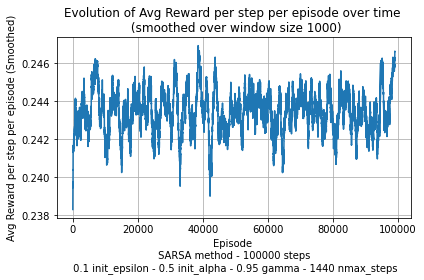

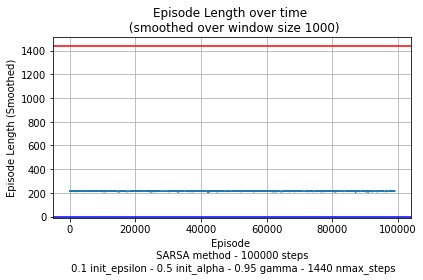

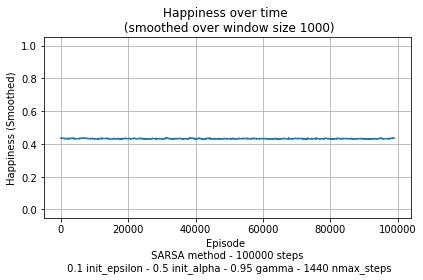

In [44]:
plot_evolution_reward(evo_training['evo_avg_reward_per_step'], method_name)
plot_evolution_steps(evo_training['evo_n_steps'], method_name)
plot_evolution_happiness(evo_training['evo_avg_happiness'], method_name)

In [45]:
Q

defaultdict(<function __main__.init_Q.<locals>.get_default_Q_values()>,
            {'0.5000_0.0000_0.5000_True': array([1.40548728, 1.00367129, 1.00376552, 1.00726826]),
             '0.4900_0.0000_0.4900_True': array([1.        , 1.28690754, 1.        , 1.        ]),
             '0.4800_0.0000_0.4800_False': array([1.23317463, 0.96      , 1.        , 1.        ]),
             '0.4700_0.0000_0.4700_False': array([1.21527307, 0.955     , 0.99590909, 1.        ]),
             '0.4600_0.0000_0.4600_False': array([1.20908264, 0.99802002, 0.99545455, 0.95      ]),
             '0.4500_0.0000_0.4500_False': array([1.21367419, 1.        , 0.945     , 1.        ]),
             '0.4400_0.0000_0.4400_False': array([1.20145221, 1.        , 0.94      , 1.        ]),
             '0.4300_0.0000_0.4300_False': array([1.18441086, 0.935     , 0.99409091, 0.99690476]),
             '0.4200_0.0000_0.4200_False': array([1.19001524, 0.93      , 1.        , 0.99363636]),
             '0.4100_0.0000_0.

# Training the learning agent - Q-learning

In [46]:
method = 'Q-Learning'
method_name = method

## Initialisation

In [47]:
# Initializing the Q-matrix 
Q = init_Q(n_actions, init_Q_type)
Q_saved = Q.copy()

In [48]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

checking = {
    'Kullback_Leibler_divergence': []
    , 'explained_variance': []
}

In [49]:
# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
}

for_explained_variance = {
    'empirical_return': []
    , 'predicted_value': []
}

## Training

  1%|          | 996/100000 [00:13<19:39, 83.90it/s]

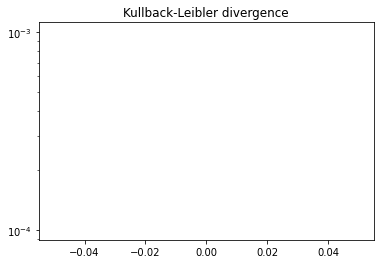

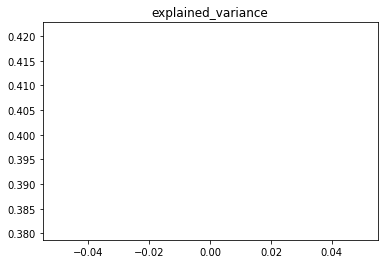

  2%|▏         | 1996/100000 [00:30<22:40, 72.02it/s]  

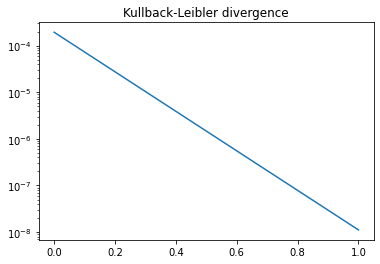

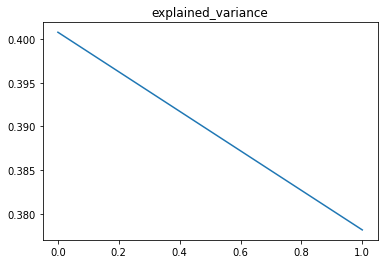

  3%|▎         | 2996/100000 [00:48<21:00, 76.95it/s]  

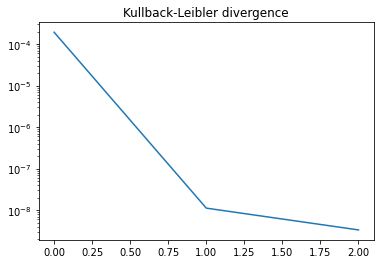

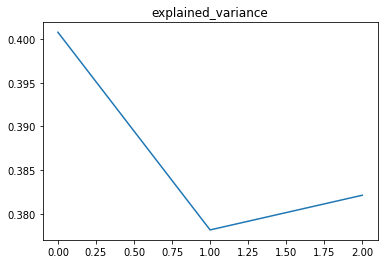

  4%|▍         | 3997/100000 [01:07<25:10, 63.56it/s]  

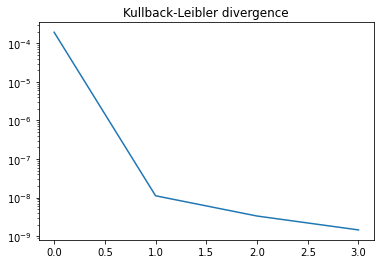

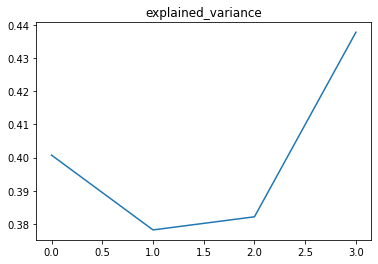

  5%|▍         | 4991/100000 [01:26<20:05, 78.80it/s]  

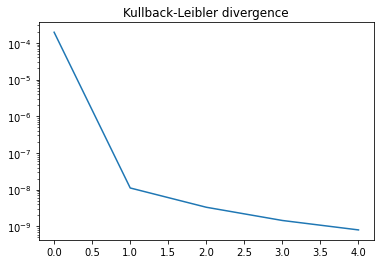

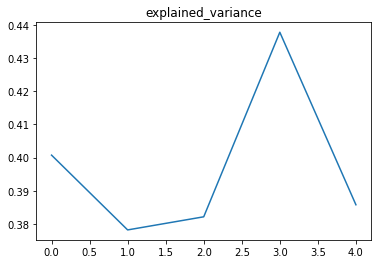

  6%|▌         | 5992/100000 [01:46<20:59, 74.64it/s]  

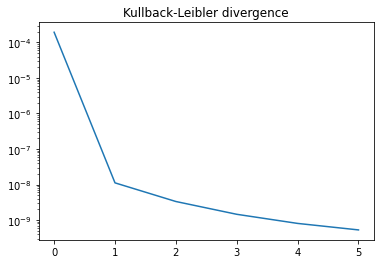

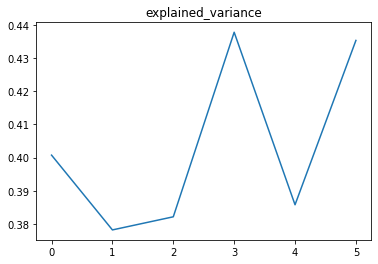

  7%|▋         | 6993/100000 [02:05<23:50, 65.02it/s]  

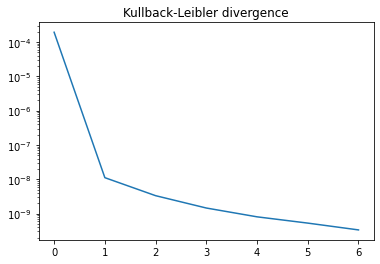

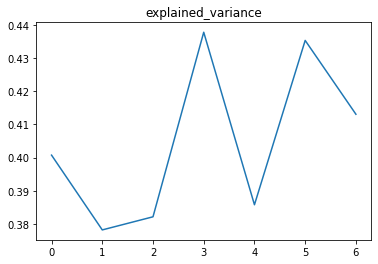

  8%|▊         | 7996/100000 [02:25<21:58, 69.76it/s]  

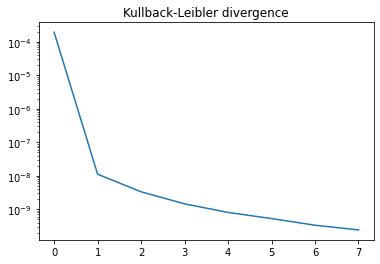

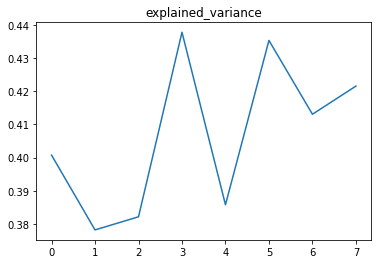

  9%|▉         | 8993/100000 [02:46<19:08, 79.23it/s]  

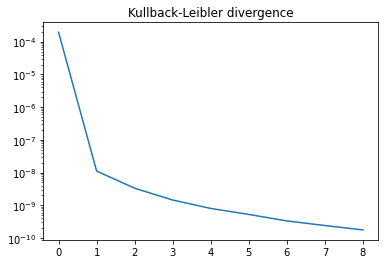

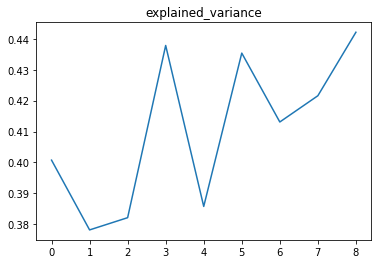

 10%|▉         | 9994/100000 [03:06<20:25, 73.47it/s]  

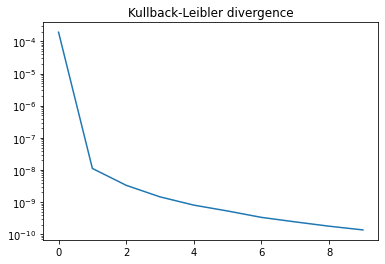

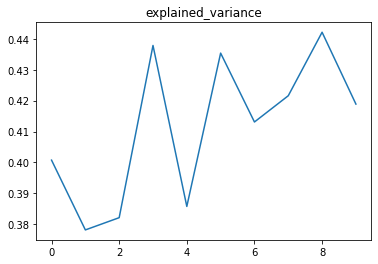

 11%|█         | 10998/100000 [03:27<19:38, 75.51it/s]  

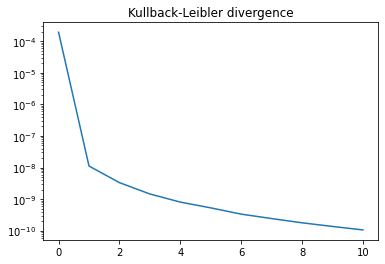

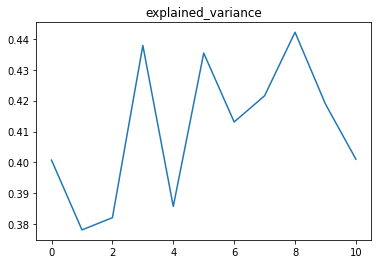

 12%|█▏        | 11990/100000 [03:47<22:01, 66.61it/s]  

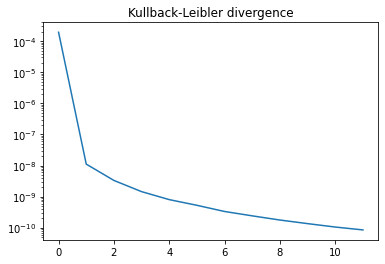

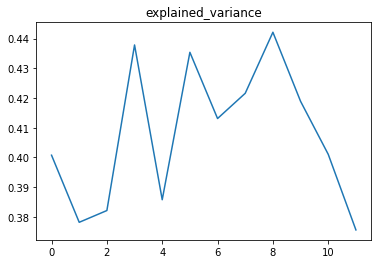

 13%|█▎        | 12999/100000 [04:08<22:48, 63.58it/s]  

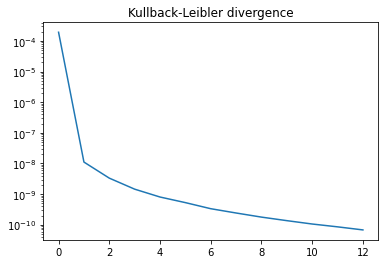

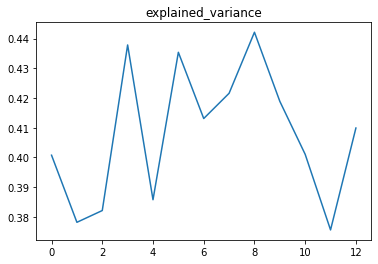

 14%|█▍        | 13991/100000 [04:29<19:42, 72.72it/s]  

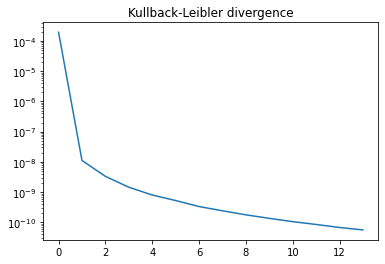

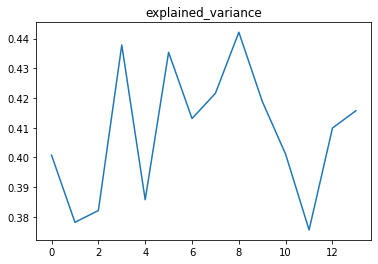

 15%|█▍        | 14991/100000 [04:50<18:43, 75.64it/s]  

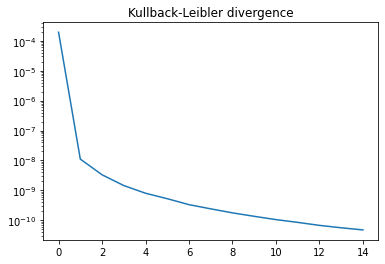

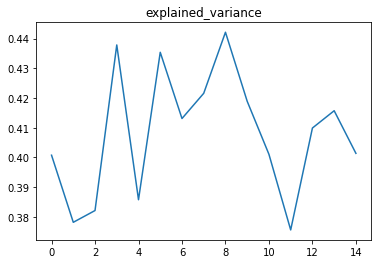

 16%|█▌        | 15998/100000 [05:12<21:02, 66.54it/s]  

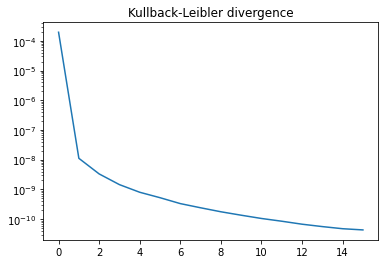

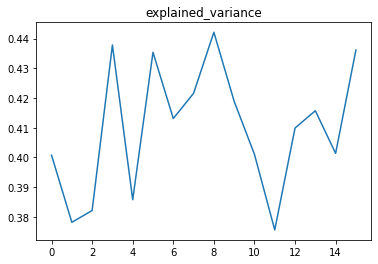

 17%|█▋        | 16999/100000 [05:34<22:32, 61.35it/s]  

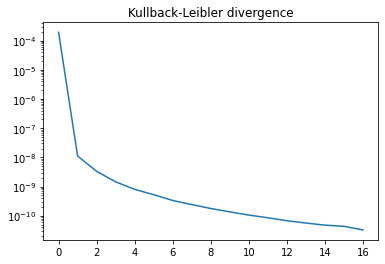

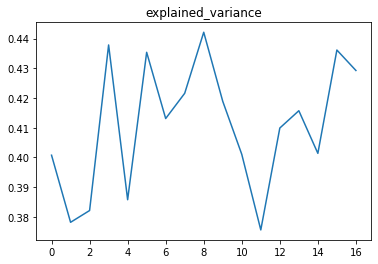

 18%|█▊        | 17994/100000 [05:56<20:06, 67.95it/s]  

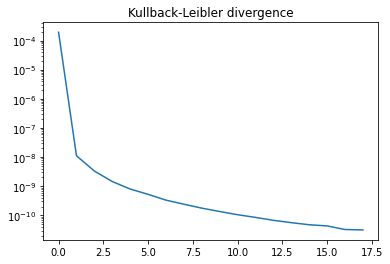

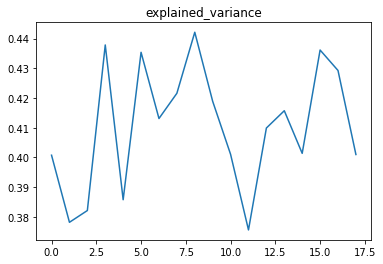

 19%|█▉        | 18996/100000 [06:20<20:38, 65.41it/s]  

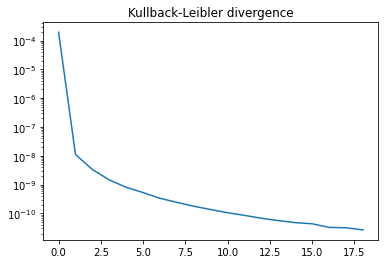

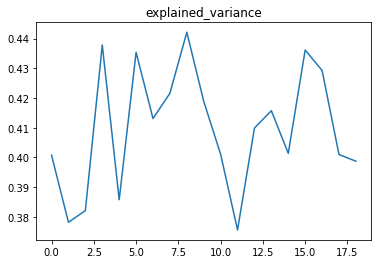

 20%|█▉        | 19994/100000 [06:42<21:36, 61.73it/s]  

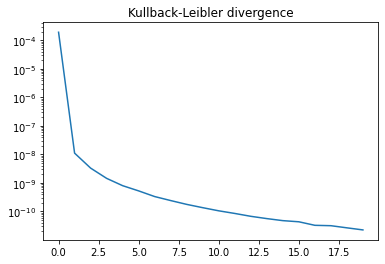

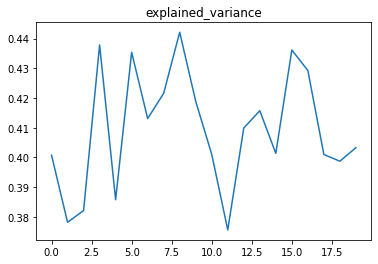

 21%|██        | 20999/100000 [07:07<20:29, 64.24it/s]  

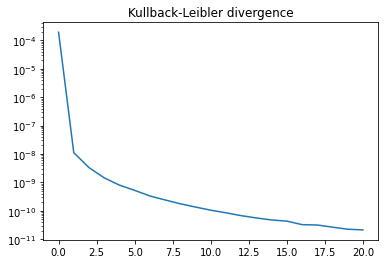

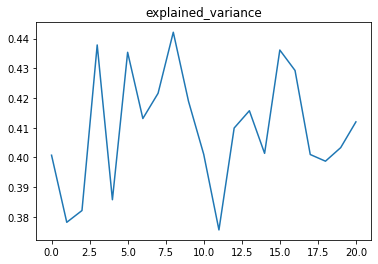

 22%|██▏       | 21995/100000 [07:30<20:25, 63.66it/s]  

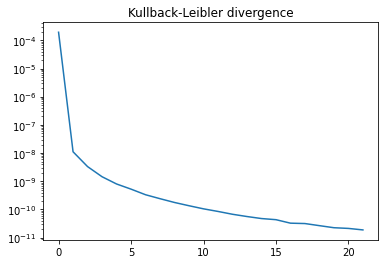

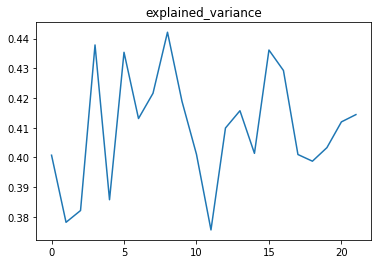

 23%|██▎       | 22998/100000 [07:54<22:25, 57.25it/s]  

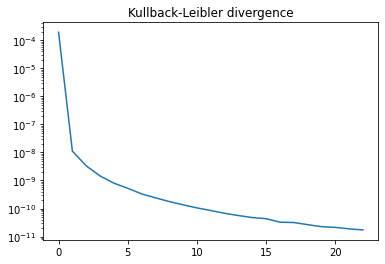

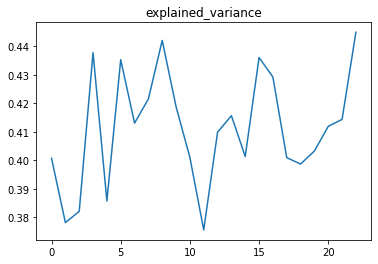

 24%|██▍       | 23992/100000 [08:17<17:53, 70.83it/s]  

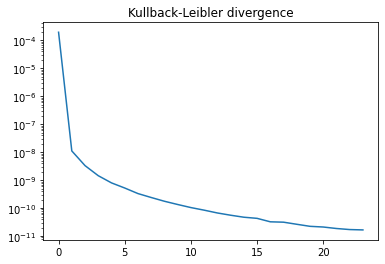

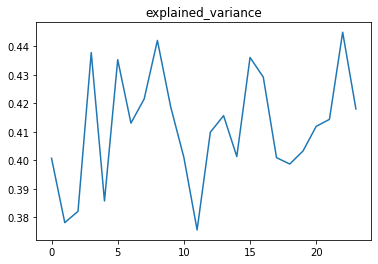

 25%|██▍       | 24996/100000 [08:40<18:52, 66.25it/s]  

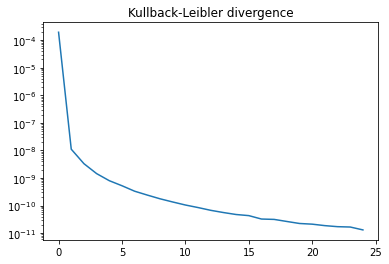

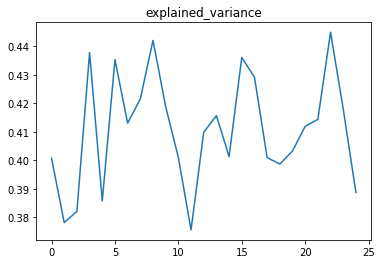

 26%|██▌       | 25993/100000 [09:04<18:18, 67.40it/s]  

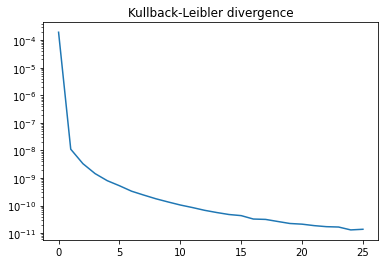

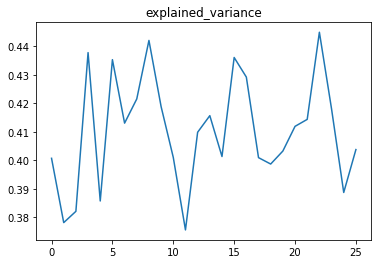

 27%|██▋       | 26998/100000 [09:27<14:59, 81.12it/s]  

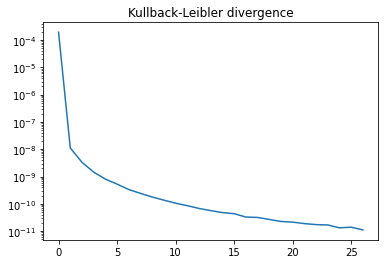

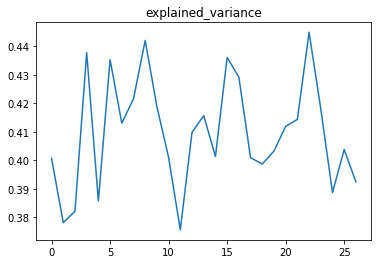

 28%|██▊       | 27997/100000 [09:51<16:47, 71.48it/s]  

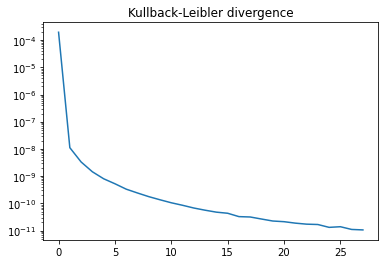

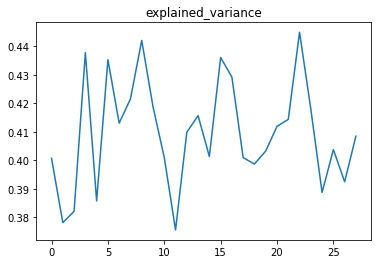

 29%|██▉       | 28994/100000 [10:15<19:24, 60.97it/s]  

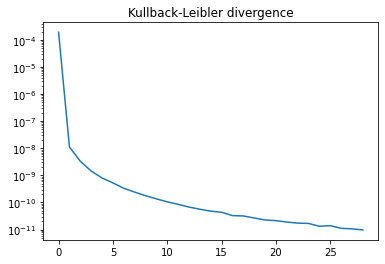

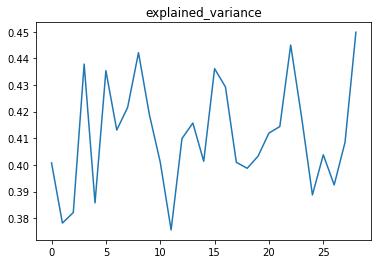

 30%|██▉       | 29995/100000 [10:39<16:04, 72.61it/s]  

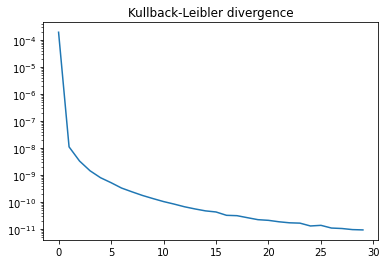

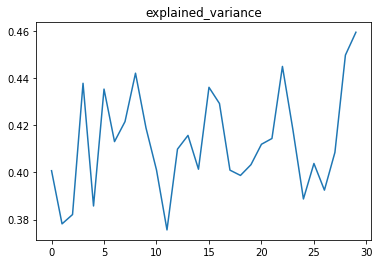

 31%|███       | 30994/100000 [11:03<19:19, 59.52it/s]  

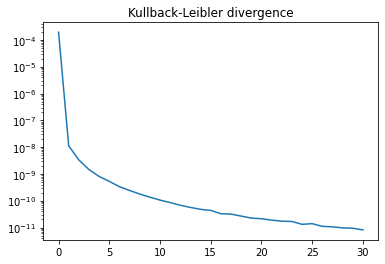

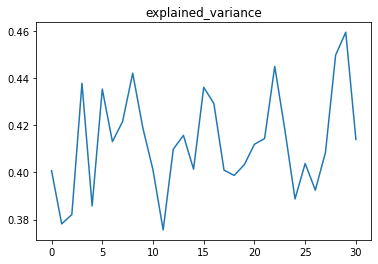

 32%|███▏      | 31992/100000 [11:28<15:49, 71.64it/s]  

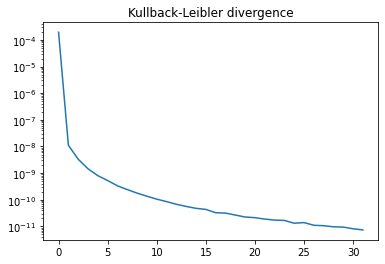

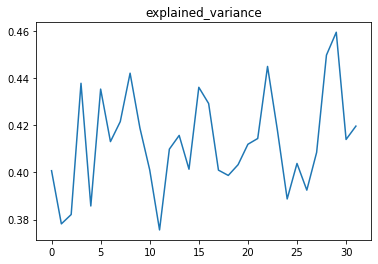

 33%|███▎      | 32994/100000 [11:51<16:53, 66.09it/s]  

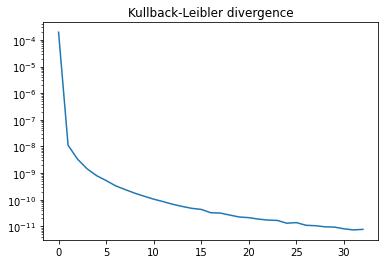

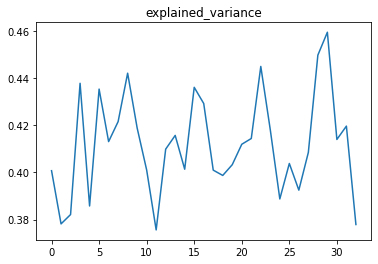

 34%|███▍      | 33992/100000 [12:16<16:24, 67.03it/s]  

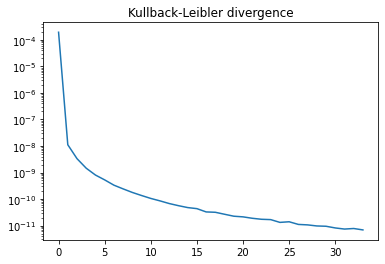

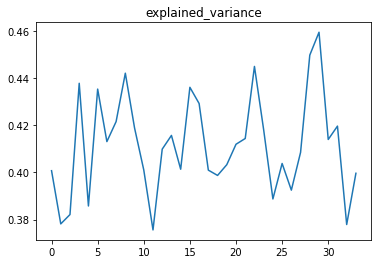

 35%|███▍      | 34997/100000 [12:41<17:04, 63.47it/s]  

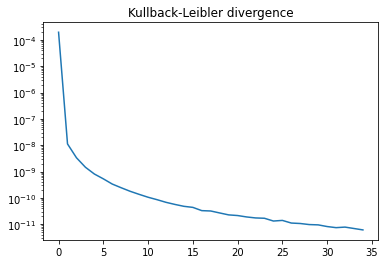

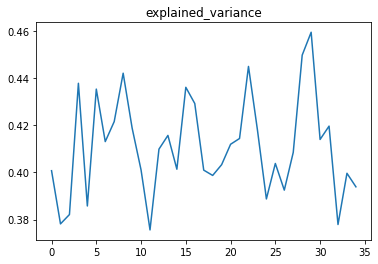

 36%|███▌      | 35992/100000 [13:05<14:53, 71.62it/s]  

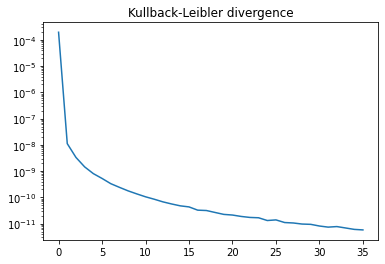

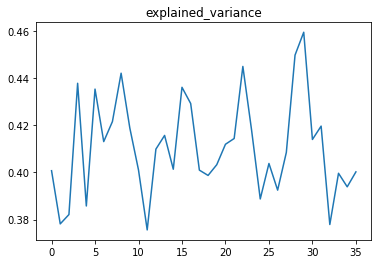

 37%|███▋      | 36994/100000 [13:30<15:04, 69.66it/s]  

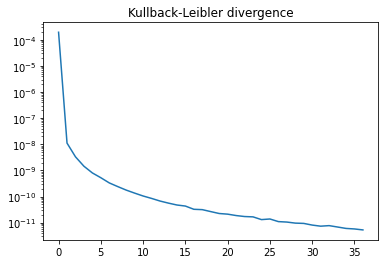

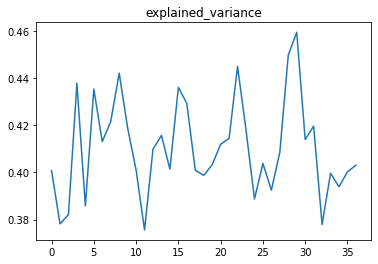

 38%|███▊      | 37991/100000 [13:54<14:33, 70.98it/s]  

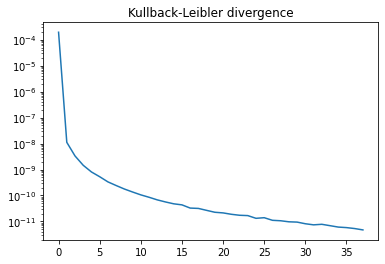

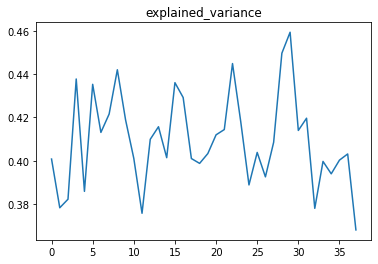

 39%|███▉      | 38992/100000 [14:20<13:59, 72.65it/s]  

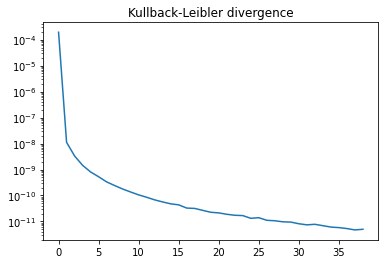

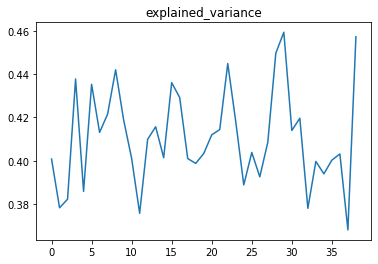

 40%|███▉      | 39999/100000 [14:45<15:05, 66.26it/s]  

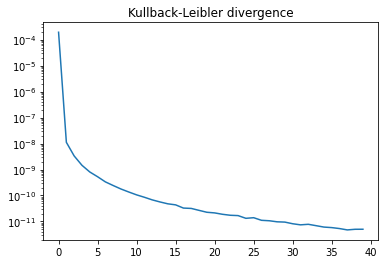

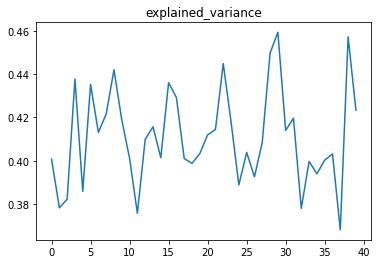

 41%|████      | 40994/100000 [15:11<15:54, 61.82it/s]  

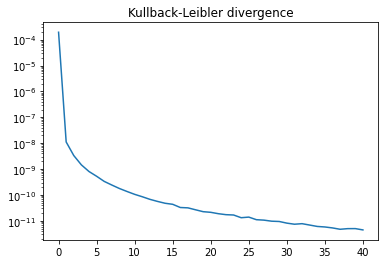

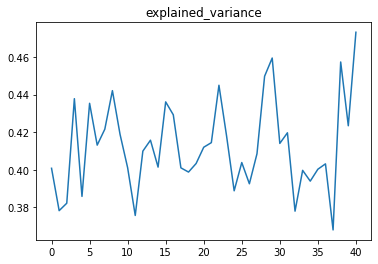

 42%|████▏     | 41998/100000 [15:37<14:39, 65.97it/s]  

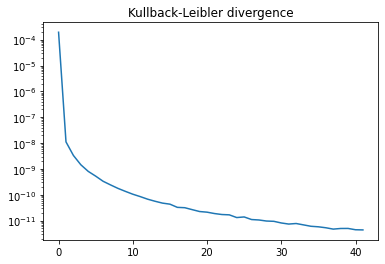

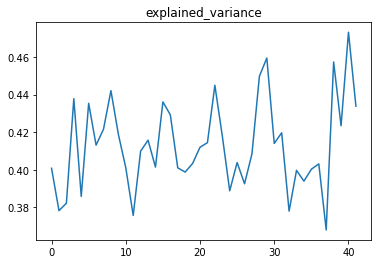

 43%|████▎     | 42992/100000 [16:02<13:44, 69.12it/s]  

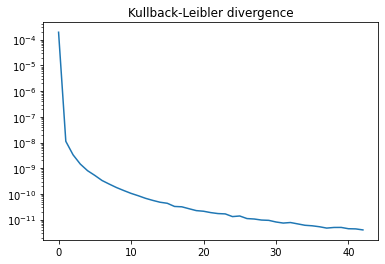

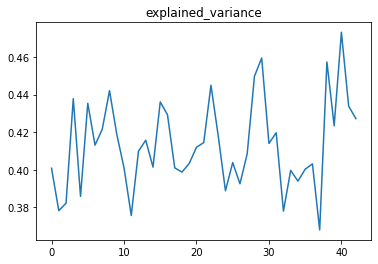

 44%|████▍     | 43993/100000 [16:27<15:11, 61.42it/s]  

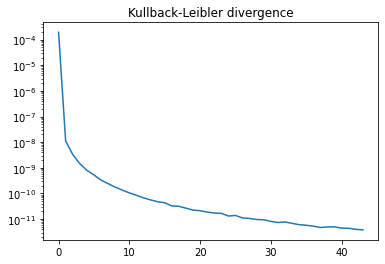

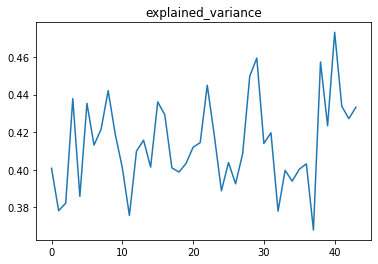

 45%|████▍     | 44993/100000 [16:52<12:15, 74.76it/s]  

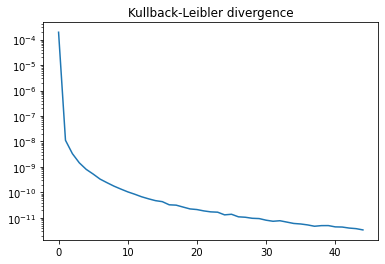

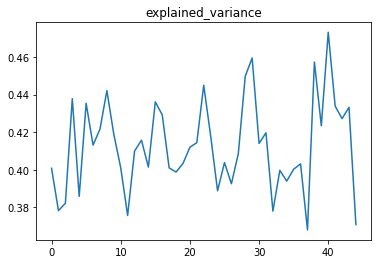

 46%|████▌     | 45993/100000 [17:16<12:51, 70.02it/s]  

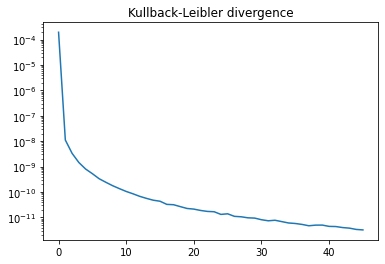

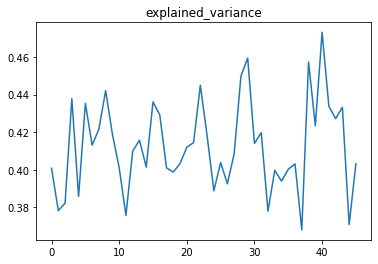

 47%|████▋     | 46999/100000 [17:41<12:19, 71.66it/s]  

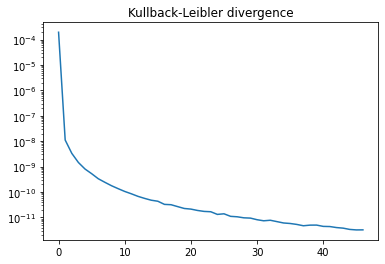

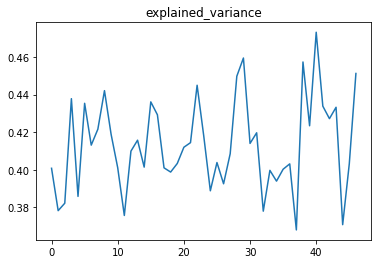

 48%|████▊     | 47995/100000 [18:06<13:08, 65.94it/s]  

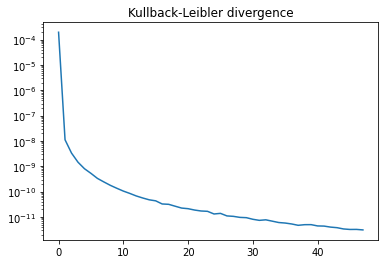

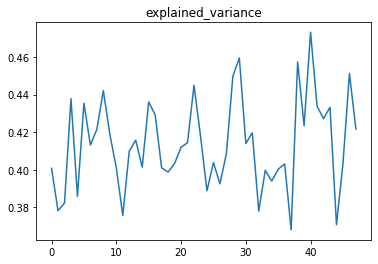

 49%|████▉     | 48997/100000 [18:30<14:56, 56.88it/s]  

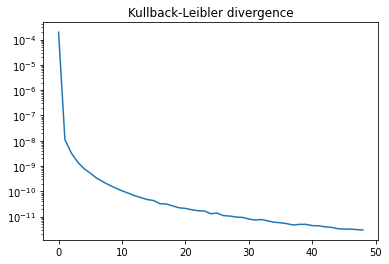

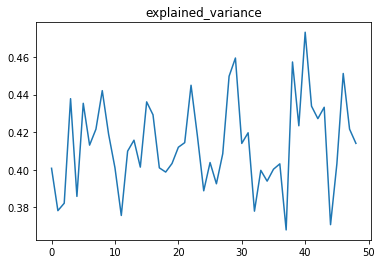

 50%|████▉     | 49999/100000 [18:55<14:24, 57.81it/s]  

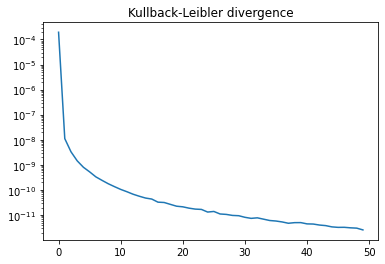

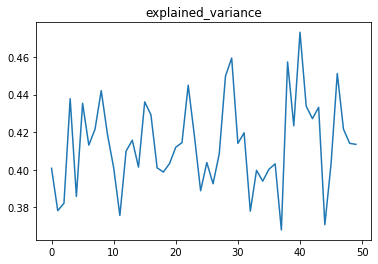

 51%|█████     | 50990/100000 [19:19<12:22, 65.97it/s]  

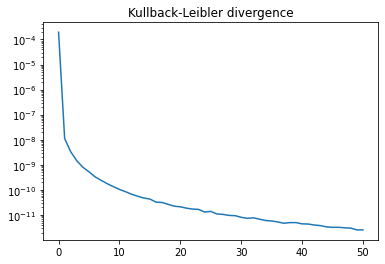

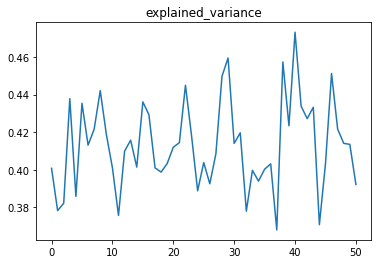

 52%|█████▏    | 51996/100000 [19:43<13:35, 58.84it/s]  

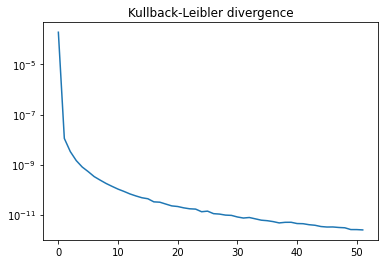

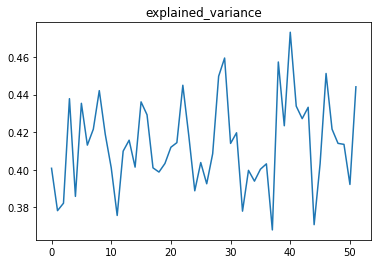

 53%|█████▎    | 52994/100000 [20:07<11:24, 68.71it/s]  

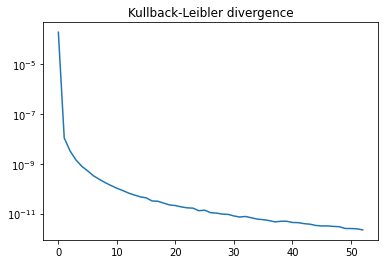

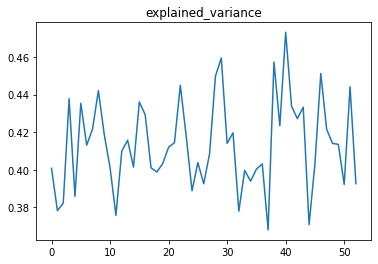

 54%|█████▍    | 53996/100000 [20:32<10:57, 70.02it/s]  

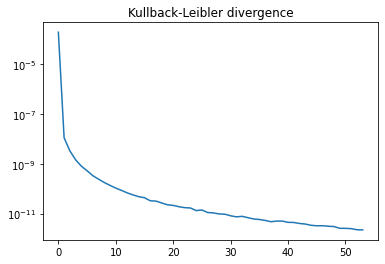

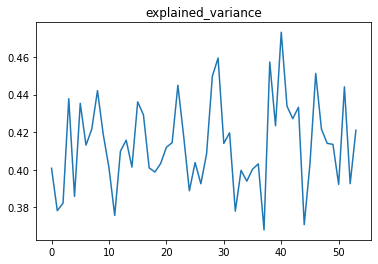

 55%|█████▍    | 54993/100000 [20:56<10:25, 72.00it/s]   

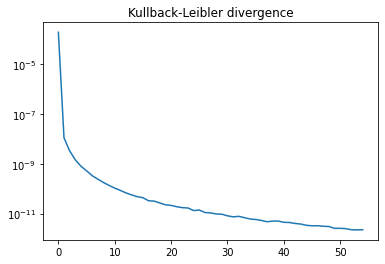

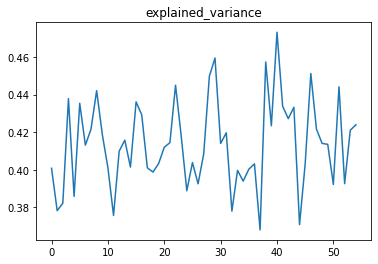

 56%|█████▌    | 55998/100000 [21:21<12:00, 61.05it/s]  

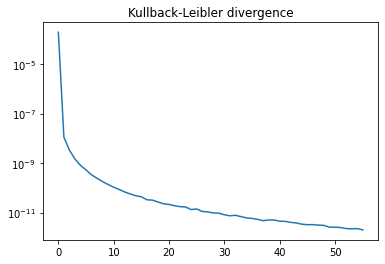

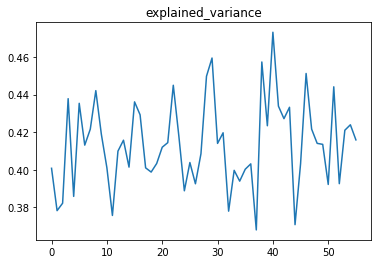

 57%|█████▋    | 56994/100000 [21:45<09:35, 74.67it/s]  

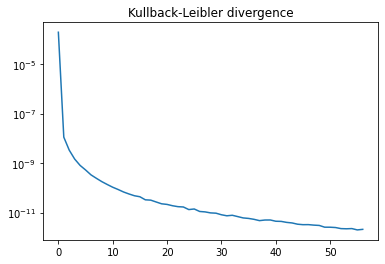

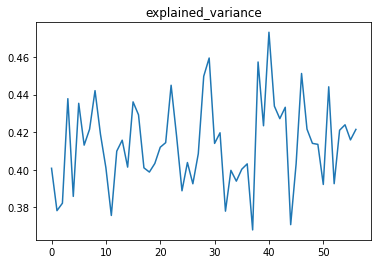

 58%|█████▊    | 57996/100000 [22:10<10:41, 65.52it/s]  

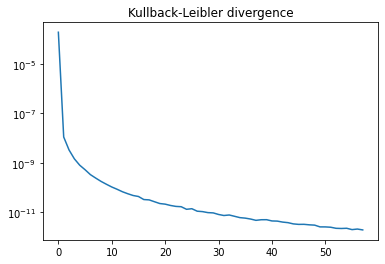

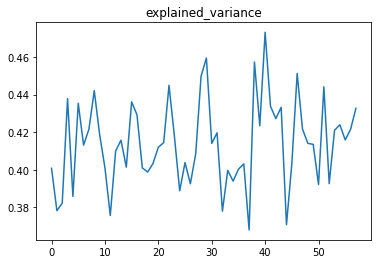

 59%|█████▉    | 58999/100000 [22:35<10:10, 67.16it/s]  

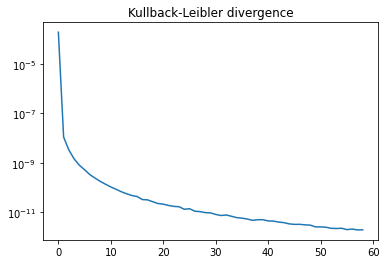

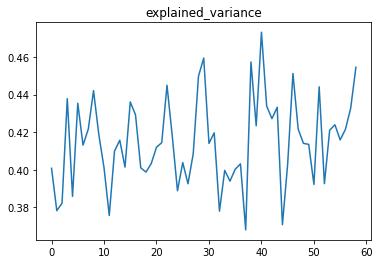

 60%|█████▉    | 59990/100000 [22:59<10:04, 66.15it/s]  

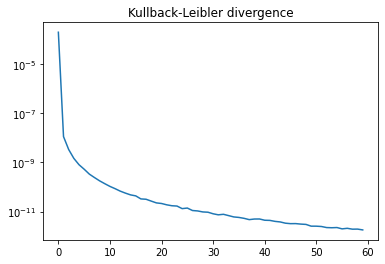

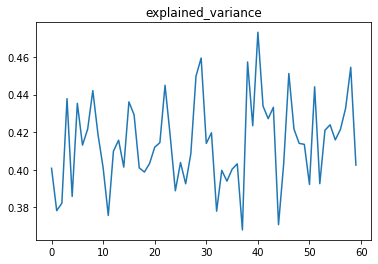

 61%|██████    | 60994/100000 [23:24<09:43, 66.89it/s]  

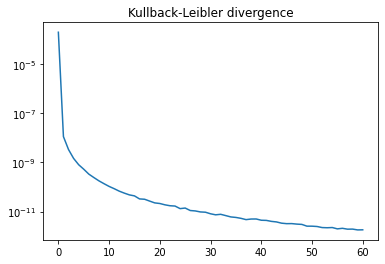

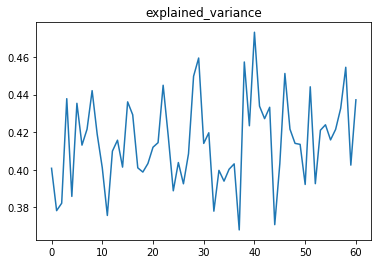

 62%|██████▏   | 61996/100000 [23:50<08:46, 72.23it/s]  

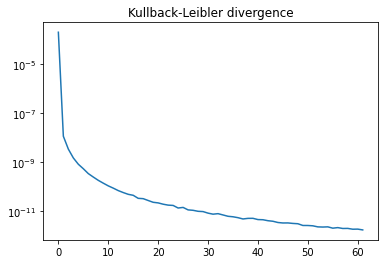

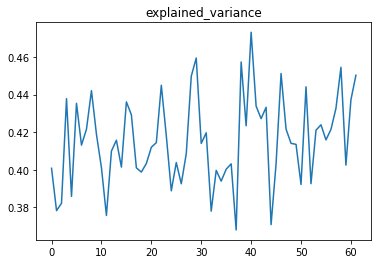

 63%|██████▎   | 62997/100000 [24:15<08:22, 73.67it/s]  

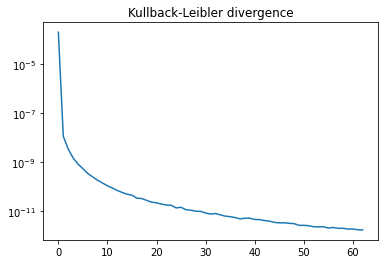

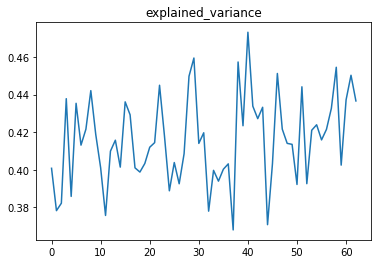

 64%|██████▍   | 63997/100000 [24:39<08:47, 68.26it/s]  

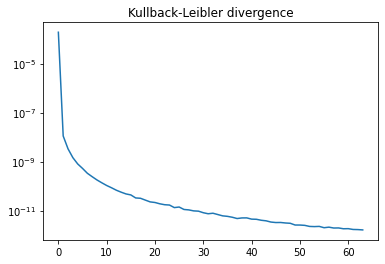

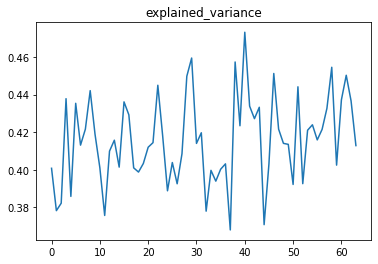

 65%|██████▍   | 64993/100000 [25:05<08:45, 66.62it/s]  

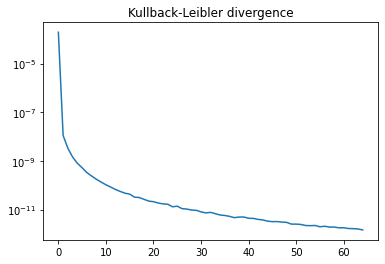

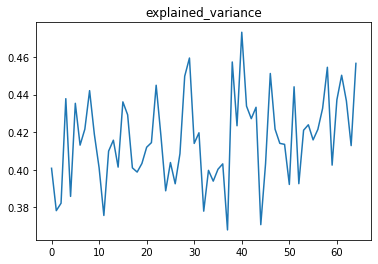

 66%|██████▌   | 65997/100000 [25:30<06:37, 85.59it/s]  

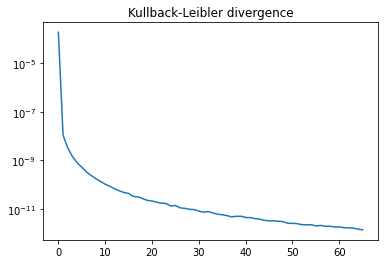

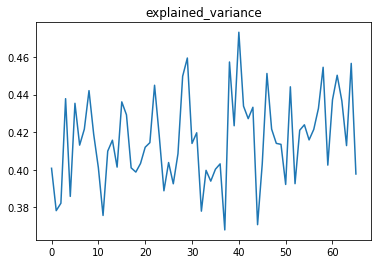

 67%|██████▋   | 66997/100000 [25:54<08:37, 63.81it/s]  

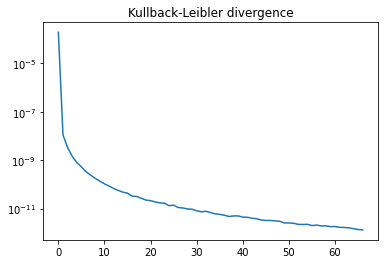

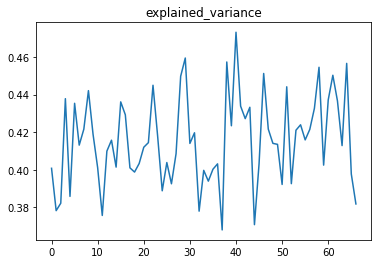

 68%|██████▊   | 67994/100000 [26:19<07:45, 68.75it/s]  

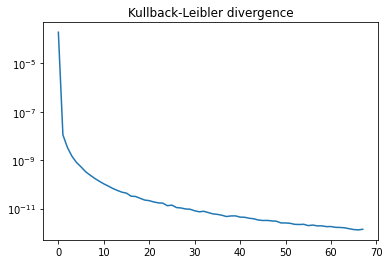

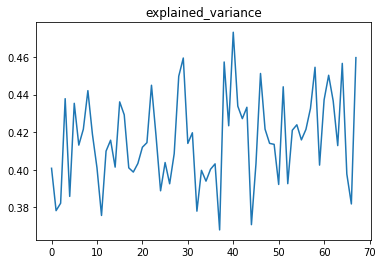

 69%|██████▉   | 68992/100000 [26:45<07:09, 72.26it/s]  

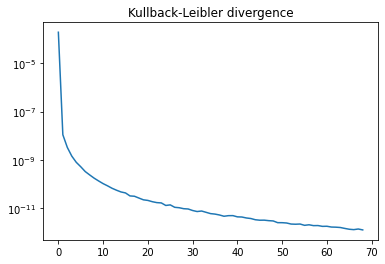

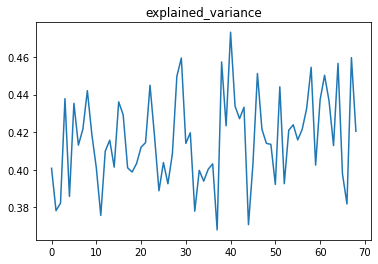

 70%|██████▉   | 69993/100000 [27:10<07:02, 71.07it/s]  

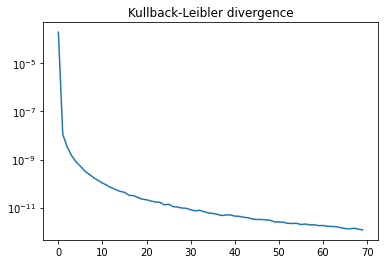

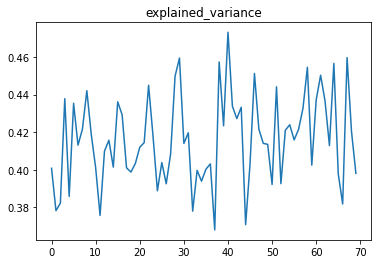

 71%|███████   | 70991/100000 [27:34<07:09, 67.56it/s]  

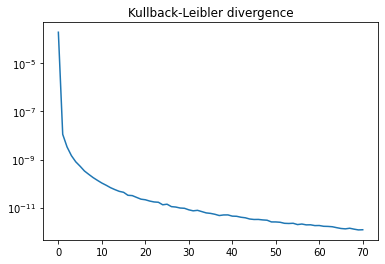

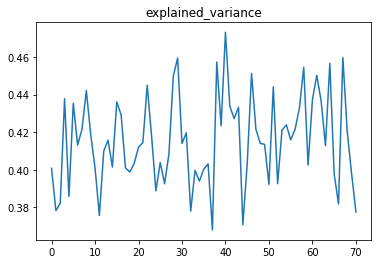

 72%|███████▏  | 71998/100000 [27:59<06:25, 72.63it/s]  

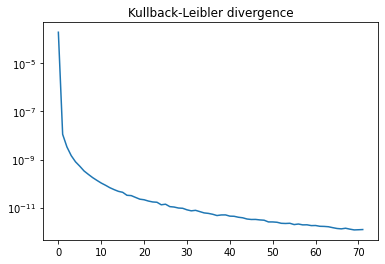

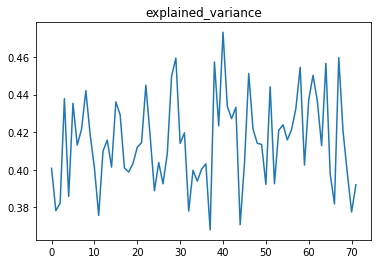

 73%|███████▎  | 72993/100000 [28:25<05:22, 83.86it/s]  

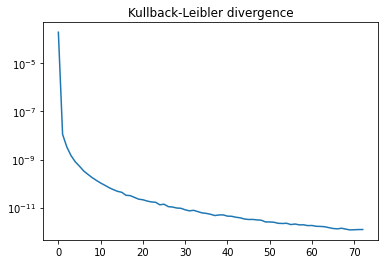

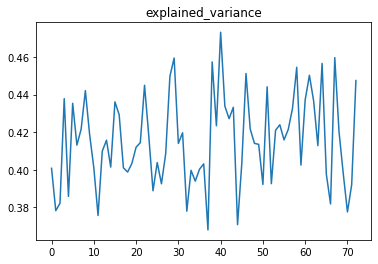

 74%|███████▍  | 73990/100000 [28:50<06:17, 68.94it/s]  

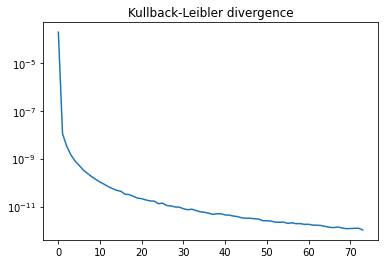

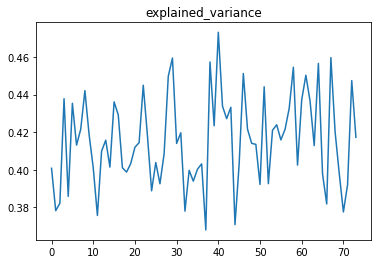

 75%|███████▍  | 74992/100000 [29:15<06:20, 65.66it/s]  

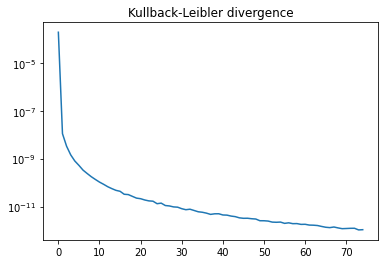

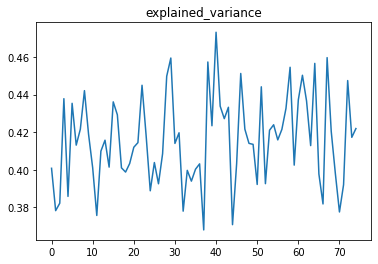

 76%|███████▌  | 75993/100000 [29:40<06:02, 66.16it/s]  

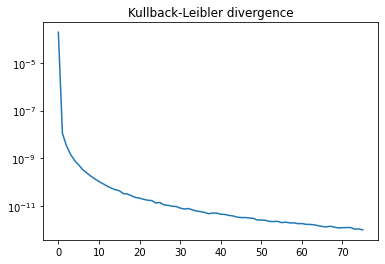

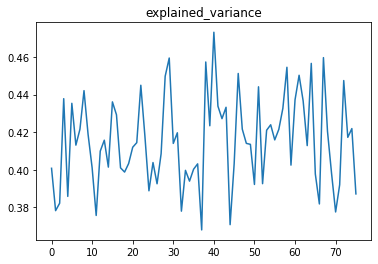

 77%|███████▋  | 76996/100000 [30:06<05:14, 73.16it/s]  

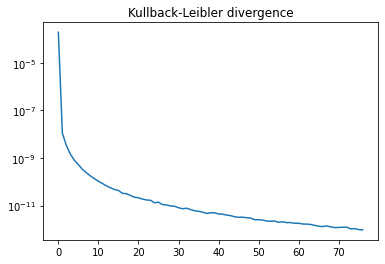

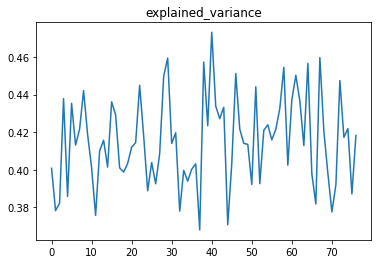

 78%|███████▊  | 77997/100000 [30:32<05:29, 66.71it/s]  

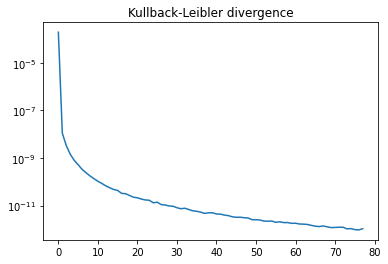

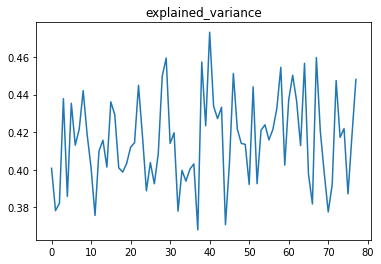

 79%|███████▉  | 78996/100000 [30:58<04:31, 77.39it/s]  

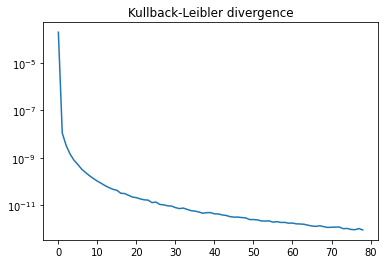

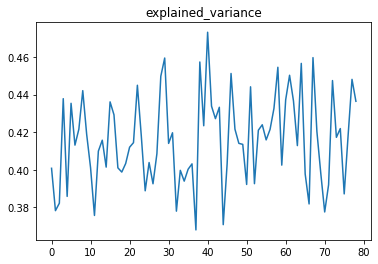

 80%|███████▉  | 79996/100000 [31:23<05:16, 63.17it/s]  

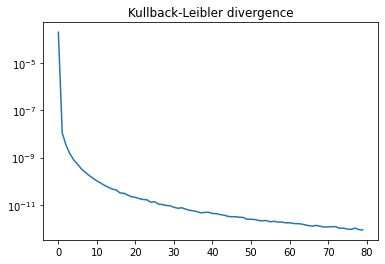

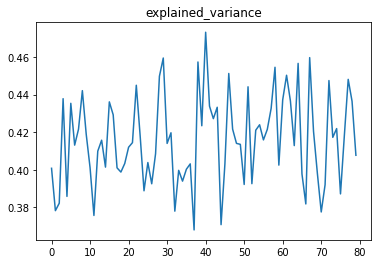

 81%|████████  | 80997/100000 [31:48<04:29, 70.44it/s]  

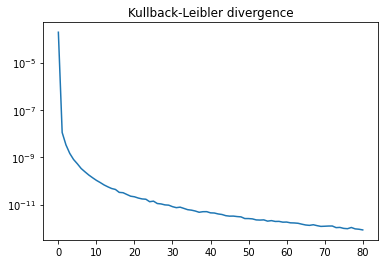

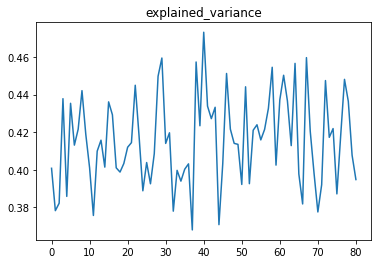

 82%|████████▏ | 81991/100000 [32:14<04:26, 67.67it/s]  

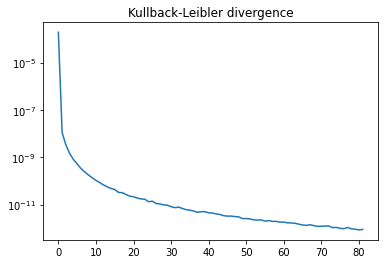

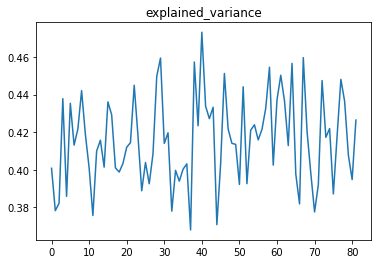

 83%|████████▎ | 82999/100000 [32:40<03:42, 76.51it/s]  

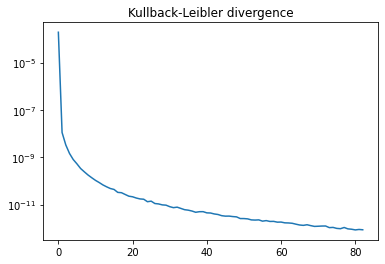

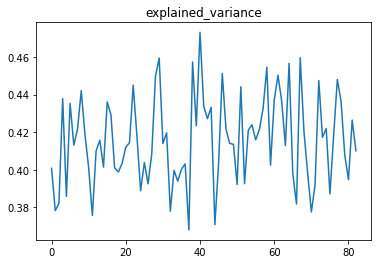

 84%|████████▍ | 83999/100000 [33:05<04:28, 59.60it/s]  

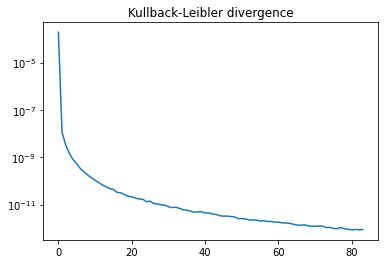

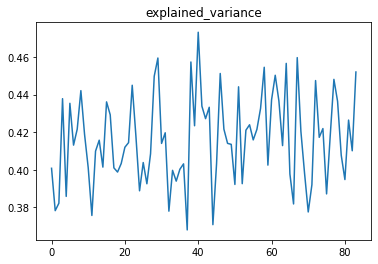

 85%|████████▍ | 84999/100000 [33:31<03:54, 63.85it/s]  

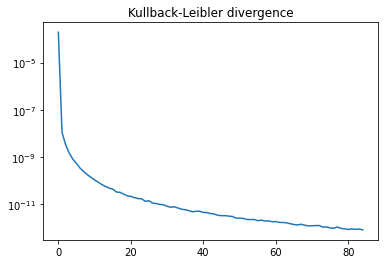

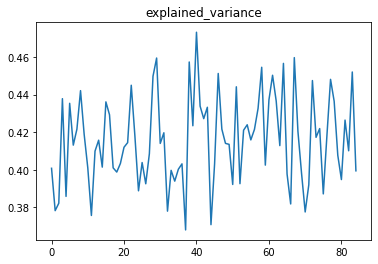

 86%|████████▌ | 85997/100000 [33:57<03:11, 73.12it/s]  

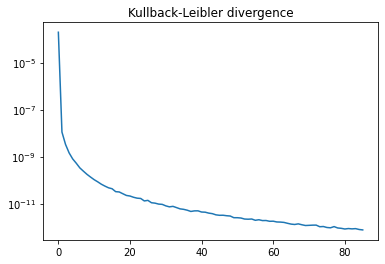

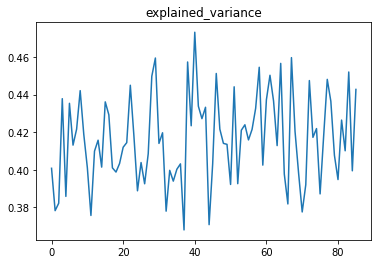

 87%|████████▋ | 86991/100000 [34:23<03:19, 65.22it/s]  

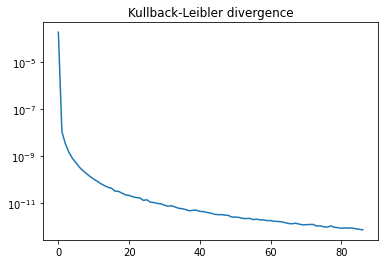

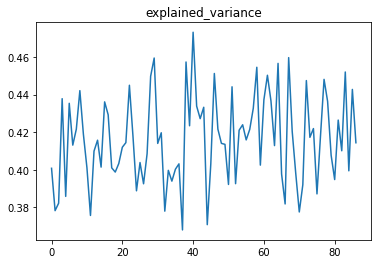

 88%|████████▊ | 87989/100000 [34:49<02:51, 70.04it/s]  

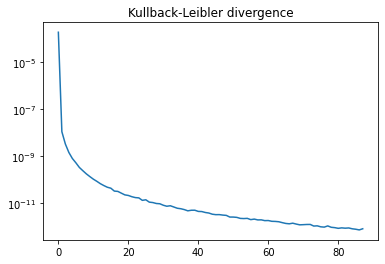

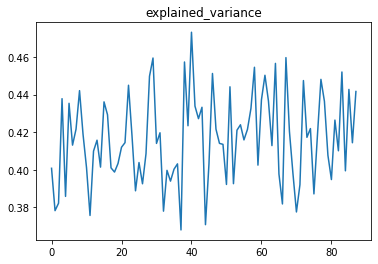

 89%|████████▉ | 88997/100000 [35:14<02:39, 69.18it/s]  

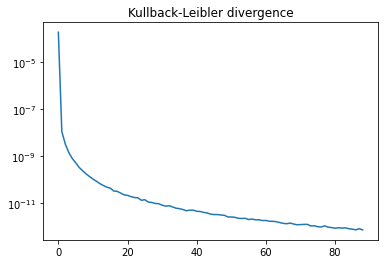

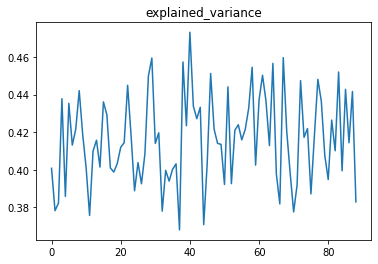

 90%|████████▉ | 89992/100000 [35:40<02:14, 74.56it/s]  

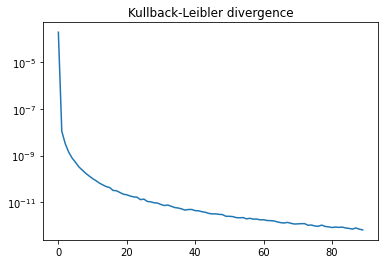

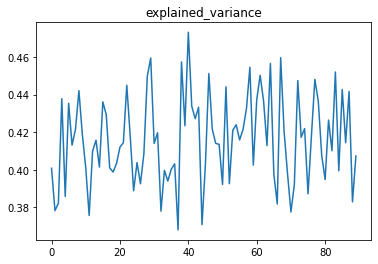

 91%|█████████ | 90993/100000 [36:06<02:07, 70.87it/s]  

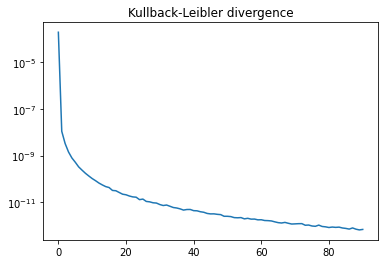

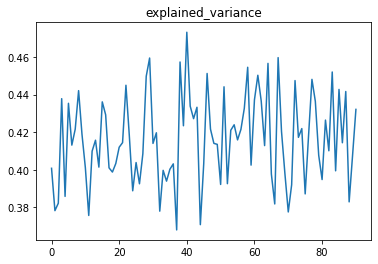

 92%|█████████▏| 91993/100000 [36:32<01:40, 79.68it/s]  

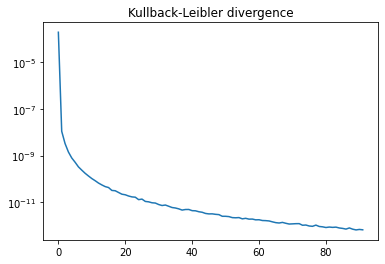

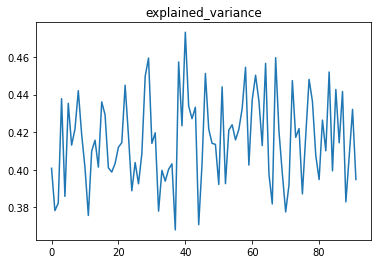

 93%|█████████▎| 92993/100000 [36:58<01:50, 63.38it/s]

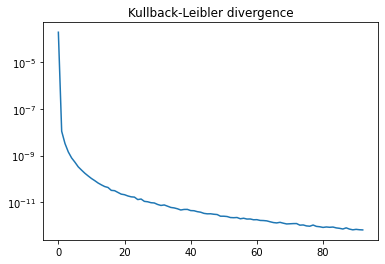

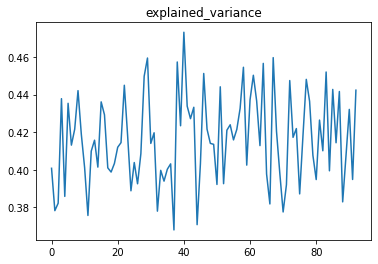

 94%|█████████▍| 93990/100000 [37:24<01:25, 70.01it/s]  

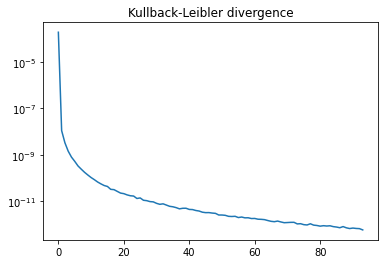

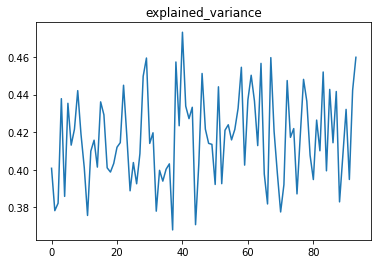

 95%|█████████▍| 94998/100000 [37:50<01:13, 67.60it/s]

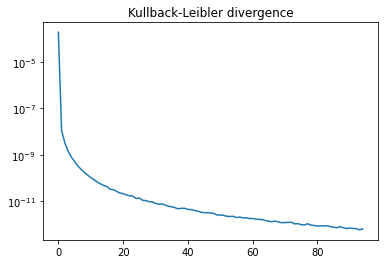

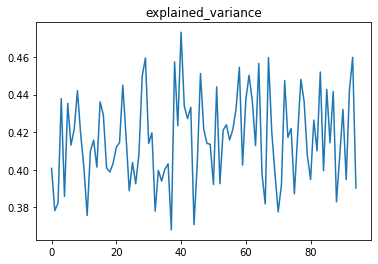

 96%|█████████▌| 95992/100000 [38:17<00:52, 76.42it/s]

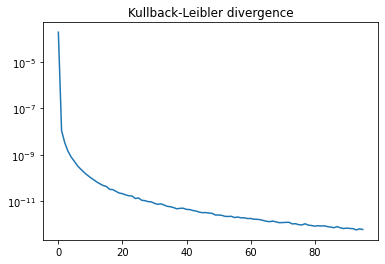

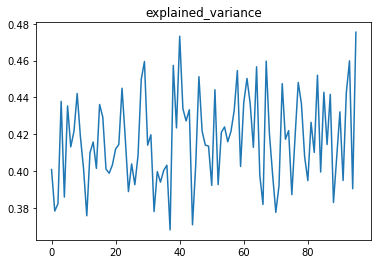

 97%|█████████▋| 96991/100000 [38:43<00:37, 80.29it/s]

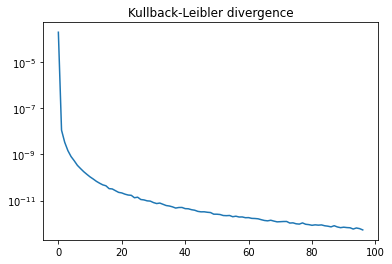

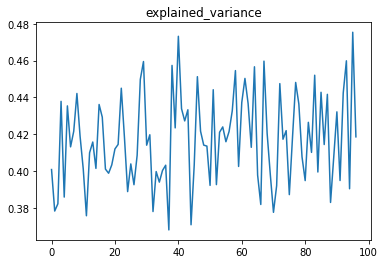

 98%|█████████▊| 97998/100000 [39:09<00:26, 74.21it/s]

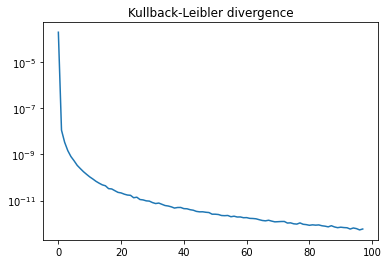

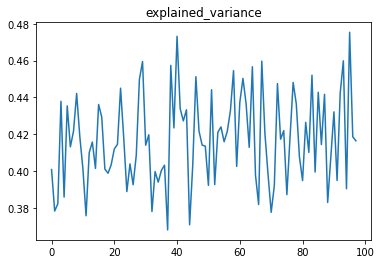

 99%|█████████▉| 98997/100000 [39:35<00:15, 64.14it/s]

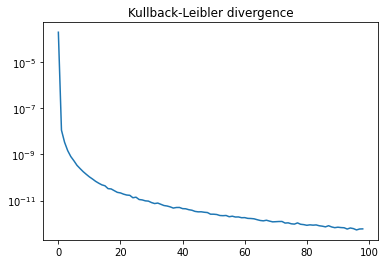

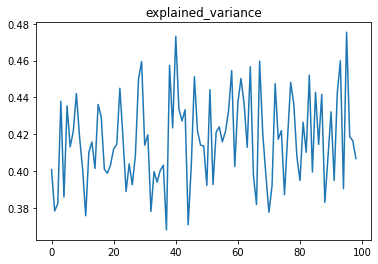

100%|█████████▉| 99999/100000 [40:01<00:00, 64.74it/s]

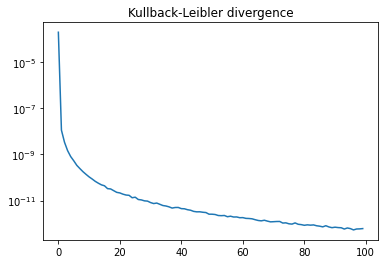

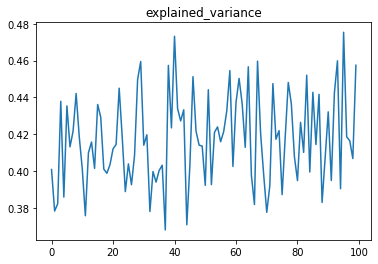

100%|██████████| 100000/100000 [40:13<00:00, 41.43it/s]


In [50]:
# Starting the SARSA learning 
for episode in tqdm(range(n_episodes)):
    
    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }
    
    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)
    
    # Get episode

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)

    while (not done) and (n_episode_steps < nmax_steps):
        
        # Choose an action
        action1 = epsilon_greedy(Q, state1['state_id'], n_actions, init_epsilon)

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)
        
        for_explained_variance['empirical_return'].append(reward1)
        for_explained_variance['predicted_value'].append(Q[state1['state_id']][action1])
        

        # Q-Learning
        # Choosing the next action 
        action2 = select_best_action(Q[state2['state_id']])
        # Learning the Q-value
        Q = update_Q_Qlearning(Q, state1['state_id'], action1, reward1, state2['state_id'], action2)
        
        # Updating the respective values 
        state1 = state2
        n_episode_steps += 1
    
    
    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Score: {1}, Timesteps: {2}, Epsilon: {3}, Alpha: {4}'.format(
            episode+1, episode_reward, n_episode_steps, epsilon, alpha))
    
    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / n_episode_steps)
    evo_training['evo_n_steps'].append(n_episode_steps)
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / n_episode_steps)
    
    if ((episode+1) % n_episodes_plot == 0) | (episode == (n_episodes-1)):
        
        checking['Kullback_Leibler_divergence'].append(calculate_KLdiv(Q_saved, Q))        
        Q_saved = Q.copy()
        y = checking['Kullback_Leibler_divergence']
        x = range(len(y))
        plt.figure()
        plt.plot(x, y)
        plt.title('Kullback-Leibler divergence')
        plt.yscale('log')
        plt.show()
        
        checking['explained_variance'].append(calculate_explained_variance(
            for_explained_variance['empirical_return'],
            for_explained_variance['predicted_value']))
        for_explained_variance = {'empirical_return': [], 'predicted_value': []}
        
        y = checking['explained_variance']
        x = range(len(y))
        plt.figure()
        plt.plot(x, y)
        plt.title('explained_variance')
        plt.show()
        
        with open('data/interim/{}__Q.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q, file)

        with open('data/interim/{}__evo_training.pkl'.format(method_name), 'wb') as file:
            dill.dump(evo_training, file)

with open('models/{}__Q.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q, file)
with open('models/{}__evo_training.pkl'.format(method_name), 'wb') as file:
    dill.dump(evo_training, file)

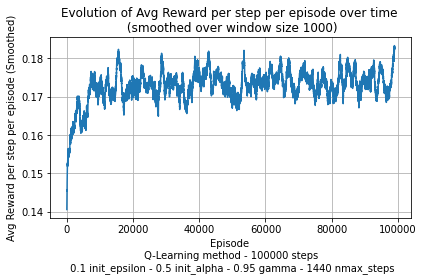

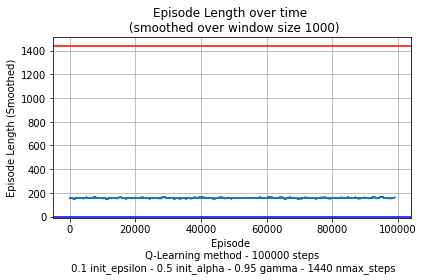

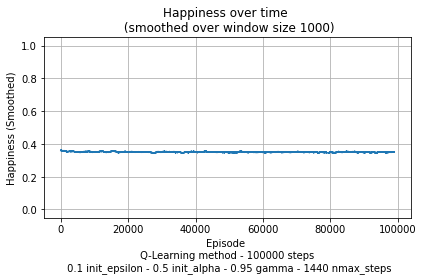

In [51]:
plot_evolution_reward(evo_training['evo_avg_reward_per_step'], method_name)
plot_evolution_steps(evo_training['evo_n_steps'], method_name)
plot_evolution_happiness(evo_training['evo_avg_happiness'], method_name)

# Training the learning agent - Double Q-learning

In [52]:
method = 'Double-Q-Learning'
method_name = method

## Initialisation

In [53]:
# Initializing the Q-matrix 
Q1 = init_Q(n_actions, init_Q_type)
Q2 = init_Q(n_actions, init_Q_type)

In [54]:
# Visualisation
(render_episode, render_training) = (False, False)
n_episodes_plot = int(np.ceil(n_episodes/100))

In [55]:
# Initializing the reward
evo_training = {
    'evo_avg_reward_per_step': []
    , 'evo_n_steps': []
    , 'evo_avg_happiness': []
}

## Training

In [56]:
# Starting the learning 
for episode in tqdm(range(n_episodes)):
    #episode = 0

    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'episode_sum_reward': 0
        , 'evolution_sum_happiness': 0
    }

    # Update parameters
    epsilon = get_epsilon(episode, init_epsilon)
    alpha = get_alpha(episode, init_alpha)

    # Get episode

    state1 = env_reset()
    evo_episode['evolution_sum_happiness'] += get_happiness(state1)

    while (not done) and (n_episode_steps < nmax_steps):

        # Choose an action
        action1 = epsilon_greedy(Q1, state1['state_id'], n_actions, init_epsilon, Q2)

        # Getting the next state 
        state2, reward1, done, info = env_step(state1, action1)
        evo_episode['episode_sum_reward'] += reward1
        evo_episode['evolution_sum_happiness'] += get_happiness(state2)


        # Double Q-Learning
        if rng.uniform(0, 1) < 0.5:
            # Choosing the next action 
            action2 = select_best_action(Q1[state2['state_id']])
            # Learning the Q-value
            Q1 = update_Q_doubleQlearning(Q1, Q2, state1['state_id'], action1, reward1, state2['state_id'], action2)
        else:
            # Choosing the next action 
            action2 = select_best_action(Q2[state2['state_id']])
            # Learning the Q-value
            Q2 = update_Q_doubleQlearning(Q2, Q1, state1['state_id'], action1, reward1, state2['state_id'], action2)

        # Updating the respective values 
        state1 = state2
        n_episode_steps += 1

    # At the end of learning process 
    if render_episode:
        print('Episode {0}, Avg Reward: {1}, Timesteps: {2}, Avg Happiness: {3}, Epsilon: {4}, Alpha: {5}'.format(
            episode+1, evo_episode['episode_sum_reward'] / n_episode_steps, n_episode_steps,
            evo_episode['evolution_sum_happiness'] / n_episode_steps, epsilon, alpha))

    evo_training['evo_avg_reward_per_step'].append(evo_episode['episode_sum_reward'] / n_episode_steps)
    evo_training['evo_n_steps'].append(n_episode_steps)
    evo_training['evo_avg_happiness'].append(evo_episode['evolution_sum_happiness'] / n_episode_steps)

    if ((episode+1) % n_episodes_plot == 0) | (episode == (n_episodes-1)):

        with open('data/interim/{}__Q1.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q1, file)

        with open('data/interim/{}__Q2.pkl'.format(method_name), 'wb') as file:
            dill.dump(Q2, file)

        with open('data/interim/{}__evo_training.pkl'.format(method_name), 'wb') as file:
            dill.dump(evo_training, file)

with open('models/{}__Q1.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q1, file)
with open('models/{}__Q2.pkl'.format(method_name), 'wb') as file:
    dill.dump(Q2, file)
with open('models/{}__evo_training.pkl'.format(method_name), 'wb') as file:
    dill.dump(evo_training, file)

100%|██████████| 100000/100000 [41:55<00:00, 39.75it/s]  


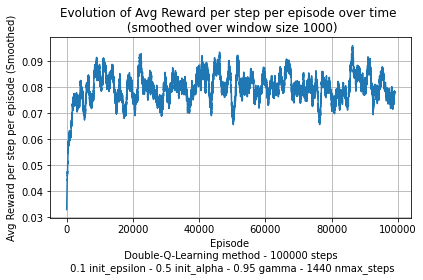

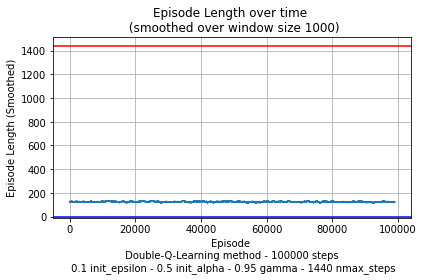

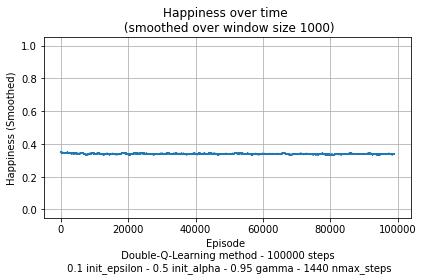

In [57]:
plot_evolution_reward(evo_training['evo_avg_reward_per_step'], method_name)
plot_evolution_steps(evo_training['evo_n_steps'], method_name)
plot_evolution_happiness(evo_training['evo_avg_happiness'], method_name)

# Comparison

In [58]:
# list_methods = ['MC_every_visit','MC_first_visit', 'SARSA', 'Q-Learning', 'Double-Q-Learning']
list_methods = ['SARSA', 'Q-Learning', 'Double-Q-Learning']

## Evolution of Reward / Steps / Happiness

In [59]:
evo_training__evo_avg_reward_per_step = {}
evo_training__evo_n_steps = {}
evo_training__evo_avg_happiness = {}

for method in list_methods:
    with open("models/{}__evo_training.pkl".format(method), "rb") as input_file:
        evo_training = dill.load(input_file)

    evo_training__evo_avg_reward_per_step[method] = evo_training['evo_avg_reward_per_step']
    evo_training__evo_n_steps[method] = evo_training['evo_n_steps']
    evo_training__evo_avg_happiness[method] = evo_training['evo_avg_happiness']

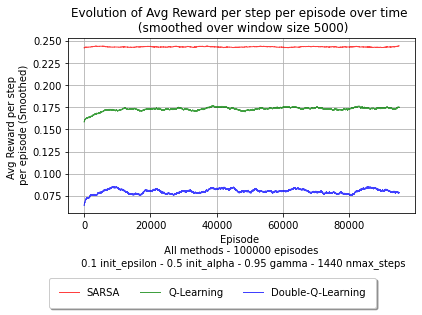

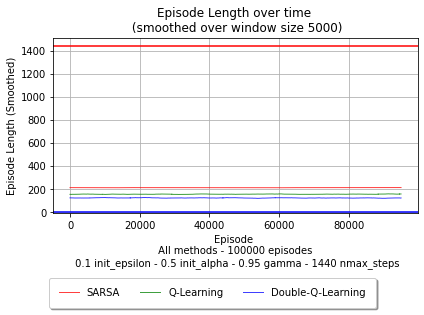

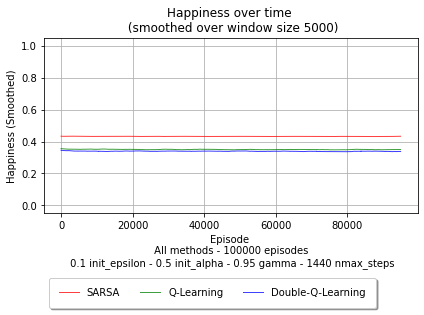

In [60]:
plot_comparison_evolution_reward(evo_training__evo_avg_reward_per_step)
plot_comparison_evolution_steps(evo_training__evo_n_steps)
plot_comparison_evolution_happiness(evo_training__evo_avg_happiness)

## Simulated episodes

In [61]:
# Variables
nmax_steps = 2000
render_episode = False
evo_all_methods = {}

Method SARSA, Avg Reward: 0.2468, Timesteps: 170, Avg Happiness: 0.4521


NameError: name 'fig' is not defined

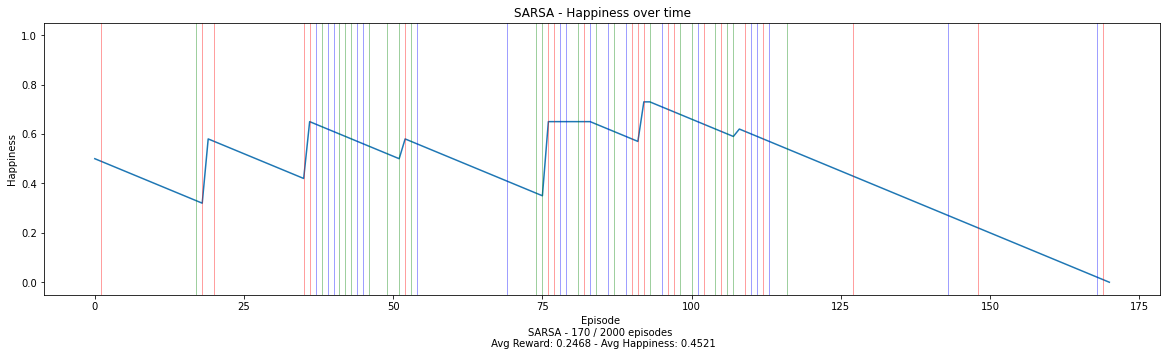

In [62]:
for method in list_methods:
    #method = 'Double-Q-Learning'

    if method == 'Double-Q-Learning':
        with open("models/{}__Q1.pkl".format(method), "rb") as input_file:
            Q1 = dill.load(input_file)
        with open("models/{}__Q2.pkl".format(method), "rb") as input_file:
            Q2 = dill.load(input_file)
    else:
        with open("models/{}__Q.pkl".format(method), "rb") as input_file:
            Q = dill.load(input_file)

    (n_episode_steps, done) = (0, False)
    evo_episode = {
        'action': []
        , 'reward': []
        , 'happiness': []
    }

    # Start episode and get initial observation
    state = env_reset()
    evo_episode['happiness'].append(get_happiness(state))

    while (not done) and (n_episode_steps < nmax_steps):

        # Get an action
        if method == 'Double-Q-Learning':
            action = select_best_action(Q_state = Q1[state['state_id']] + Q2[state['state_id']])
        else:
            action = select_best_action(Q_state = Q[state['state_id']])
        evo_episode['action'].append(action)
        
        # Perform a step
        state, reward, done, info = env_step(state, action)
        evo_episode['reward'].append(reward)
        evo_episode['happiness'].append(get_happiness(state))

        # Update n_steps
        n_episode_steps += 1

    evo_episode['avg_reward'] = sum(evo_episode['reward']) / n_episode_steps
    evo_episode['n_steps'] = n_episode_steps
    evo_episode['avg_happiness'] = sum(evo_episode['happiness']) / n_episode_steps

    print('Method {}, Avg Reward: {:01.4f}, Timesteps: {}, Avg Happiness: {:01.4f}'.format(
        method
        , evo_episode['avg_reward']
        , evo_episode['n_steps']
        , evo_episode['avg_happiness']))

    evo_all_methods[method] = evo_episode
    
    plot_episode_happiness(evo_episode)